# Исследовательский анализ данных о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 31 октября* 2024 года.

**Дата: 23.04.2025**

**Автор: Кулагина Алена**

<div class="alert alert-block alert-info">
О, это уже исправили - а в чате был вопрос, почему даты разные. Причём исправили, я смотрю,неправильно, - данные по 31 октября.

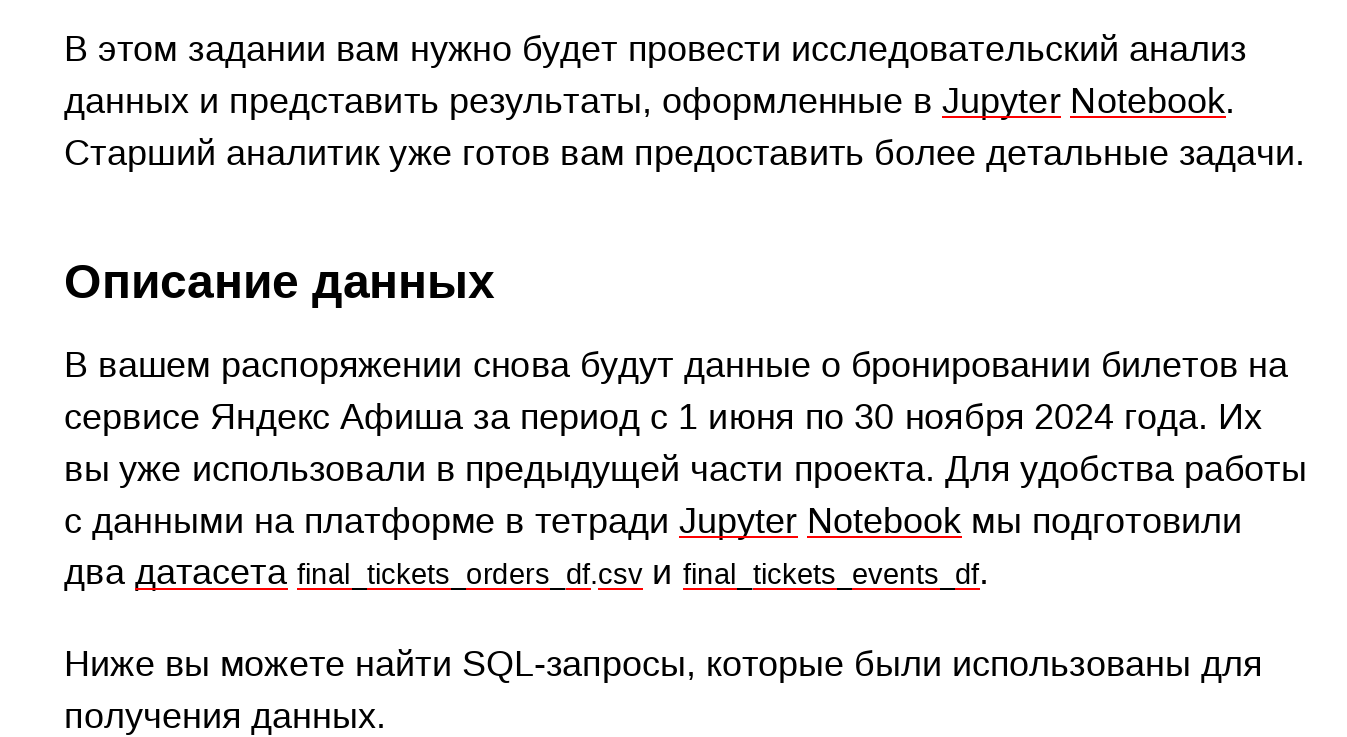

## Цели и задачи проекта

Провести исследовательский анализ данных в Python, выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

Гипотезы были выдвинуты следующие:
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

## Описание данных

1. Датасет `final_tickets_orders_df.csv` содержит информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

Поля датасета:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ: `mobile` для мобильных устройств, `desktop` для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` — количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, данные содержат пропуск.

2. Датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Из данных исключены фильмы, т.к. предыдущая часть анализа показала, что событий этого типа мало.

Поля датасета:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и т.д..
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

3. Выручка от заказов представлена в двух валютах — российских рублях и казахстанских тенге. Для удобства решения было бы корректно привести данные к одной валюте, например, к российским рублям. Для этого воспользуемся датасетом `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.

Поля датасета:
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

## Содержимое проекта

1. Загрузка и предобработка данных.


2. Исследовательский анализ данных.

    2.1. Анализ распределения заказов по сегментам и их сезонные изменения.
    
    2.2. Анализ осенней активности пользователей.
    
    2.3. Выявление популярных событий и партнёров.
    
    
3. Статистический анализ данных за осенний период.


4. Общий вывод и рекомендации

## Проект

### Загрузка и предобработка данных

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.power import TTestIndPower
from scipy.stats import mannwhitneyu

Загрузим датасет `final_tickets_orders_df.csv`.

In [102]:
orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
display(orders.head())
display(orders.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

В таблице с заказами пропуски есть только в поле `days_since_prev`, т.е. есть клиенты, которые в интересующий нас период времени делали заказ впервые.

Поля `created_dt_msk` и `created_ts_msk` нужно привести к типам даты и даты и времени соответственно.

In [103]:
orders = orders.astype({'created_dt_msk':'datetime64[ns]', 'created_ts_msk':'datetime64[ns]'})
print(f'''Первый день - {orders['created_dt_msk'].min()}, последний день - {orders['created_dt_msk'].max()}.''')
#display(orders.head())
#display(orders.info())

Первый день - 2024-06-01 00:00:00, последний день - 2024-10-31 00:00:00.


Получаем, что на самом деле данные содержат записи с 1 инюня по 31 октября 2024 года.

Загрузим датасет `final_tickets_events_df.csv`.

In [104]:
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
display(events.head())
display(events.info())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

Пропусков в данных нет, типы данных соответствуют содержимому полей.

Загрузим датасет `final_tickets_tenge_df.csv`.

In [105]:
tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
display(tenge.head())
display(tenge.info())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

Пропусков в данных нет, поле `data` требует приведения к типу даты.

In [106]:
tenge = tenge.astype({'data': 'datetime64[ns]'})

Объединим все датасеты прежде, чем производить предварительный анализ категориальных и количественных данных.

In [107]:
pd.set_option('display.max_columns', None)

oe = orders.merge(events, on = 'event_id', how = 'left')
fin = oe.merge(tenge, left_on = ['created_dt_msk', 'currency_code'], right_on = ['data', 'cdx'], how = 'left')
display(fin.head())
display(fin.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",NaT,NaN,NaN,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",NaT,NaN,NaN,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",NaT,NaN,NaN,NaN
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",NaT,NaN,NaN,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",NaT,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int64         
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int64         
 12  total                   290849

None

Создадим поле с выручкой в рублях.

In [108]:
def rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    else:
        return round(row['revenue']*row['curs']/row['nominal'], 2)

fin['revenue_rub'] = fin.apply(rub, axis=1)

Вычислим в отдельном поле выручку с каждого билета в заказе.

In [109]:
fin['one_ticket_revenue_rub'] = round(fin['revenue_rub']/fin['tickets_count'], 2)

Создадим столбцы с месяцем и сезоном заказа.

In [110]:
fin = fin.sort_values(by = 'created_ts_msk')
fin['month'] = pd.DatetimeIndex(fin['created_dt_msk']).month

In [111]:
def season(row):
    if row['month'] in [3, 4, 5]:
        return 'весна'
    elif row['month'] in [6, 7, 8]:
        return 'лето'
    elif row['month'] in [9, 10, 11]:
        return 'осень'
    else:
        return 'зима'

In [112]:
fin['season'] = fin.apply(season, axis=1)
display(fin.head())
print(fin['season'].unique())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
285516,7565637,fd4d47438ebb946,2024-06-01,2024-06-01 00:00:42,131671,нет,12,rub,mobile,1083.15,Прачечная,4,12034.97,0.0,f4431442-3d97-452d-a6d6-eadf6bd34378,спектакль,театр,№3734,Каменевский регион,Глиногорск,213.0,4019.0,"Группа исследователей искусства ""Сказка"" Лтд","алл. Шаумяна, д. 48 стр. 584",NaT,NaN,NaN,NaN,1083.15,270.79,6,лето
285517,7565521,fd4d47438ebb946,2024-06-01,2024-06-01 00:01:30,131671,нет,12,rub,mobile,812.36,Прачечная,3,9026.23,0.0,f4431442-3d97-452d-a6d6-eadf6bd34378,спектакль,театр,№3734,Каменевский регион,Глиногорск,213.0,4019.0,"Группа исследователей искусства ""Сказка"" Лтд","алл. Шаумяна, д. 48 стр. 584",NaT,NaN,NaN,NaN,812.36,270.79,6,лето
118934,6670842,57ef0a1905ac488,2024-06-01,2024-06-01 00:01:58,375861,нет,12,rub,mobile,2091.31,Билеты в руки,4,20913.12,NaN,ba89f19f-e73c-4d74-ab35-b9c023bb4de6,спектакль,театр,№1745,Лесодальний край,Родниковец,55.0,2095.0,"Молодежная творческая группа ""Студия"" Лимитед","наб. Волжская, д. 1 к. 3/9",NaT,NaN,NaN,NaN,2091.31,522.83,6,лето
285519,7565550,fd4d47438ebb946,2024-06-01,2024-06-01 00:03:13,131671,нет,12,rub,mobile,812.36,Прачечная,3,9026.23,0.0,f4431442-3d97-452d-a6d6-eadf6bd34378,спектакль,театр,№3734,Каменевский регион,Глиногорск,213.0,4019.0,"Группа исследователей искусства ""Сказка"" Лтд","алл. Шаумяна, д. 48 стр. 584",NaT,NaN,NaN,NaN,812.36,270.79,6,лето
264758,5502055,e73089d7d016cd8,2024-06-01,2024-06-01 00:03:34,211846,нет,12,rub,mobile,181.39,Прачечная,2,1813.91,0.0,20165b73-7202-48df-a5e3-fd8cd1a70554,балет,театр,№1714,Широковская область,Радужнополье,35.0,3149.0,"Дворец культуры ""Скворечник"" Инк","пер. Кочубея, д. 7/7 к. 50",NaT,NaN,NaN,NaN,181.39,90.70,6,лето


['лето' 'осень']


Проверим данные на предмет отсутствия данных и ошибок.

В полях со значениями курса тенге пропуски возникли за счёт того, что мы не подгружали данные о курсе для заказов с оплатой в рублях, т.е. нас интересовал только перевод тенге в рубли, но не наоборот.

В полях, полученных из датасета `events` есть пропуски, т.е. не обо всех мероприятиях была информация в датасете.

In [113]:
display(fin[(fin['event_type_description'].isna()) | (fin['event_type_main'].isna()) |
            (fin['region_name'].isna()) | (fin['city_name'].isna()) |
           (fin['venue_name'].isna()) | (fin['venue_address'].isna())].count())

order_id                  238
user_id                   238
created_dt_msk            238
created_ts_msk            238
event_id                  238
cinema_circuit            238
age_limit                 238
currency_code             238
device_type_canonical     238
revenue                   238
service_name              238
tickets_count             238
total                     238
days_since_prev           211
event_name                  0
event_type_description      0
event_type_main             0
organizers                  0
region_name                 0
city_name                   0
city_id                     0
venue_id                    0
venue_name                  0
venue_address               0
data                        0
nominal                     0
curs                        0
cdx                         0
revenue_rub               238
one_ticket_revenue_rub    238
month                     238
season                    238
dtype: int64

Строк со значениями `nan` всего 238.

In [114]:
print(f"""Доля строк с nan: {round(fin[(fin['event_type_description'].isna()) | (fin['event_type_main'].isna()) |
    (fin['region_name'].isna()) | (fin['city_name'].isna()) |
           (fin['venue_name'].isna()) | (fin['venue_address'].isna())].shape[0]*100 / fin.shape[0], 2)}%.""")

print(f"Всего строк: {fin.shape[0]}.")

Доля строк с nan: 0.08%.
Всего строк: 290849.


Доля строк с отсутствием информации о мероприятиях составляет всего 0.08%, что позволяет нам исключить эти строки из дальнейшего анализа.

In [115]:
fin_f = fin.drop(fin[(fin['event_type_description'].isna()) | (fin['event_type_main'].isna()) |
    (fin['region_name'].isna()) | (fin['city_name'].isna()) |
           (fin['venue_name'].isna()) | (fin['venue_address'].isna())].index)
print(f"Осталось строк: {fin_f.shape[0]}.")

Осталось строк: 290611.


Произведём предварительный анализ количественных данных, прежде всего в полях `revenue_rub` и `tickets_count`.

In [116]:
display(fin_f['tickets_count'].describe())

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Минимальное количество билетов в заказе - 1, максимальное - 57. Среднее близко к медиане, стандартное отклонение меньше среднего и медианы.

Построим диаграмму размаха числа билетов в заказе.

In [117]:
boxplot1 = fin_f.boxplot(column='tickets_count',
                     vert=False,
                     color='black',
                     flierprops=dict(markerfacecolor='gold', markeredgecolor='grey', marker='o'),
                     medianprops=dict(color="red"),
                     figsize=(10, 4))
boxplot1.set_title('Число билетов в заказе')
boxplot1.set_xlabel('Число билетов')
boxplot1.axes.get_yaxis().set_visible(False)

Для удобства анализа можем взять 99-й процентиль количества билетов в заказе, потому что все значения больше указанного - выбросы.

In [118]:
tickets_99 = np.percentile(fin_f['tickets_count'], 99)

In [119]:
display(fin_f['tickets_count'][fin_f['tickets_count']<=tickets_99].describe())

count    290423.000000
mean          2.749366
std           1.143899
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64

In [120]:
print(f"Число строк со значением количества билетов в заказе больше 99-го процентиля: {fin_f['tickets_count'][fin_f['tickets_count']>tickets_99].count()}.")
print(f"Доля этих значений: {round(fin_f['tickets_count'][fin_f['tickets_count']>tickets_99].count()*100/fin_f.shape[0], 2)}%.")

Число строк со значением количества билетов в заказе больше 99-го процентиля: 188.
Доля этих значений: 0.06%.


Строки со значениями числа билетов в заказе больше 6 составляют всего 0.06%, значит, мы можем их удалить и не учитывать в дальнейшем анализе.

In [121]:
fin_ff = fin_f[fin_f['tickets_count']<=tickets_99].reset_index()
print(f"Осталось строк: {fin_ff.shape[0]}.")

Осталось строк: 290423.


In [122]:
boxplot11 = fin_ff.boxplot(column='tickets_count',
                     vert=False,
                     color='black',
                     flierprops=dict(markerfacecolor='gold', markeredgecolor='grey', marker='o'),
                     medianprops=dict(color="red"),
                     figsize=(10, 4))
boxplot11.set_title('Число билетов в заказе')
boxplot11.set_xlabel('Число билетов')
boxplot11.axes.get_yaxis().set_visible(False)

In [123]:
fin_ff['revenue_rub'].describe()

count    290423.000000
mean        555.270038
std         875.394552
min         -90.760000
25%         113.865000
50%         350.790000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

In [124]:
display(fin_ff['revenue_rub'][fin_ff['revenue_rub']<0].describe())

count    381.000000
mean      -2.492362
std        5.065072
min      -90.760000
25%       -3.450000
50%       -1.580000
75%       -0.650000
max       -0.010000
Name: revenue_rub, dtype: float64

В столбце `revenue_rub` есть отрицательные значения.

Кроме того, стандартное отклонение намного больше медианы, а медиана и среднее отличаются, что свидетельствует о наличии выбросов.

Построим диаграмму размаха для оценки количества выбросов.

In [125]:
boxplot2 = fin_ff.boxplot(column='revenue_rub',
                     vert=False,
                     color='black',
                     flierprops=dict(markerfacecolor='gold', markeredgecolor='grey', marker='o'),
                     medianprops=dict(color="red"),
                     figsize=(10, 4))
boxplot2.set_title('Распределение выручки')
boxplot2.set_xlabel('Выручка')
boxplot2.axes.get_yaxis().set_visible(False)

In [126]:
rev_r_99 = np.percentile(fin_ff['revenue_rub'], 99)
print(rev_r_99)

2628.42


In [127]:
display(fin_ff['revenue_rub'][fin_ff['revenue_rub']<=rev_r_99].describe())

count    287606.000000
mean        517.791298
std         511.874112
min         -90.760000
25%         111.690000
50%         343.700000
75%         788.630000
max        2628.420000
Name: revenue_rub, dtype: float64

Построим диаграмму размаха, убрав из анализа отрицательные значения выручки и значения выше 99-го процентиля.

In [128]:
boxplot22 = fin_ff[(fin_ff['revenue_rub']<=rev_r_99) & (fin_ff['revenue_rub']>=0)].boxplot(column='revenue_rub',
                     vert=False,
                     color='black',
                     flierprops=dict(markerfacecolor='gold', markeredgecolor='grey', marker='o'),
                     medianprops=dict(color="red"),
                     figsize=(10, 4))
boxplot22.set_title('Распределение выручки')
boxplot22.set_xlabel('Выручка')
boxplot22.axes.get_yaxis().set_visible(False)

Оценим количество строк с отрицательными значениями выручки и со значениями выручки больше 99-го процентиля.

In [129]:
print(f"Отрицательных значений выручки: {round(fin_ff[fin_ff['revenue_rub']<0].shape[0]*100/fin_ff.shape[0], 2)}%.")
print(f"Значений больше 99-го процентиля: {round(fin_ff[fin_ff['revenue_rub']>rev_r_99].shape[0]*100/fin_ff.shape[0], 2)}%.")

Отрицательных значений выручки: 0.13%.
Значений больше 99-го процентиля: 0.97%.


В сумме таких значений 1.1%. Это позволяет нам также не использовать эти строки в дальнейшем анализе.

In [130]:
final = fin_ff[(fin_ff['revenue_rub']>=0) & (fin_ff['revenue_rub']<=rev_r_99)]

display(final.info())
print(f"Осталось строк: {final.shape[0]}.")

<class 'pandas.core.frame.DataFrame'>
Index: 287225 entries, 0 to 290422
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   index                   287225 non-null  int64         
 1   order_id                287225 non-null  int64         
 2   user_id                 287225 non-null  object        
 3   created_dt_msk          287225 non-null  datetime64[ns]
 4   created_ts_msk          287225 non-null  datetime64[ns]
 5   event_id                287225 non-null  int64         
 6   cinema_circuit          287225 non-null  object        
 7   age_limit               287225 non-null  int64         
 8   currency_code           287225 non-null  object        
 9   device_type_canonical   287225 non-null  object        
 10  revenue                 287225 non-null  float64       
 11  service_name            287225 non-null  object        
 12  tickets_count           287225 non-

None

Осталось строк: 287225.


In [131]:
print(f"""Всего строк удалено из исходного датафрейма: {fin.shape[0]-final.shape[0]}, или {round((fin.shape[0] - final.shape[0])*100 / fin.shape[0], 2)}%.""")

Всего строк удалено из исходного датафрейма: 3624, или 1.25%.


Проверим данные на явные дубликаты.

In [132]:
display(final.duplicated().sum())

np.int64(0)

Явных дубликатов не обнаружили.

Проверим данные на неявные дубликаты по всем значимым полям, без учёта идентификаторов заказов и столбца с индексом.

In [133]:
display(final[final.loc[:, (final.columns != 'index') & (final.columns != 'order_id')].duplicated()].info())

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 21315 to 288990
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   30 non-null     int64         
 1   order_id                30 non-null     int64         
 2   user_id                 30 non-null     object        
 3   created_dt_msk          30 non-null     datetime64[ns]
 4   created_ts_msk          30 non-null     datetime64[ns]
 5   event_id                30 non-null     int64         
 6   cinema_circuit          30 non-null     object        
 7   age_limit               30 non-null     int64         
 8   currency_code           30 non-null     object        
 9   device_type_canonical   30 non-null     object        
 10  revenue                 30 non-null     float64       
 11  service_name            30 non-null     object        
 12  tickets_count           30 non-null     int64    

None

Получаем 0 неявных дубликатов.

<div class="alert alert-info">
Оу, а у меня выдало 0... Удалила.

Таким образом, мы получили пригодный для дальнейшего анализа датафрейм без дубликатов, выбросов значений выручки и количества билетов в заказе. Были сформированы дополнительные столбцы с выручкой в рублях (независимо от валюты расчётов), выручкой в рублях с одного билета, месяцем заказа и указанием сезона заказа.

### Исследовательский анализ данных

#### Анализ распределения заказов по сегментам и их сезонные изменения

##### Сезонные изменения по категориям
Анализ дашборда показал, что в данных наблюдается сезонность - осенью количество заказов увеличивается.
На данном этапе анализа изучим сезонность изменения пользовательской активности. Проанализируем динамику в следующих разрезах:

- тип мероприятия `event_type_main`;
- тип устройства `device_type_canonical`;
- категория мероприятий по возрастному рейтингу `age_limit`.

In [134]:
mnth = final.groupby('month').agg({'season':'unique','order_id':'count'}).reset_index()
display(mnth.sort_values(by='order_id'))

,month,season,order_id
0,6,[лето],33785
1,7,[лето],40378
2,8,[лето],44527
3,9,[осень],69290
4,10,[осень],99245


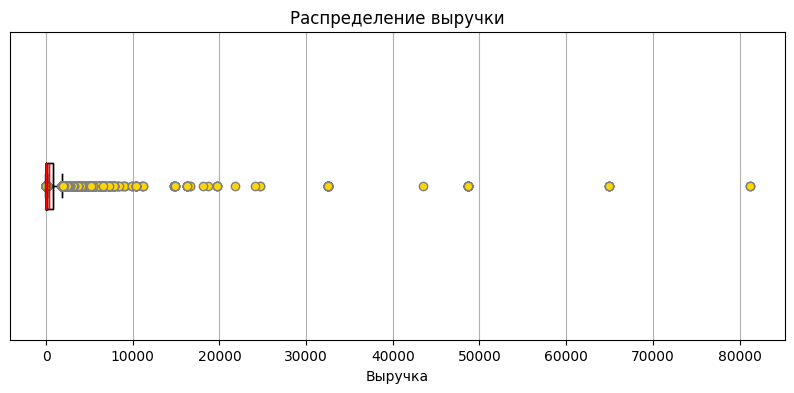

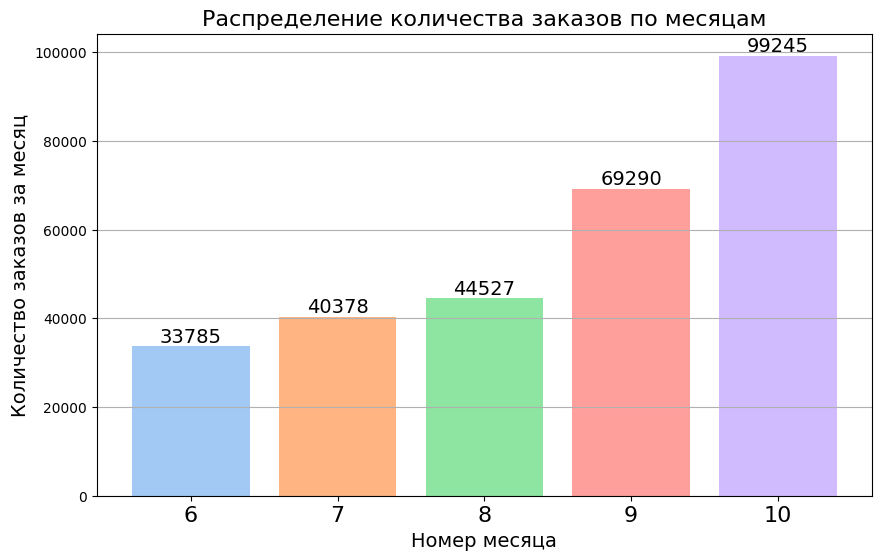

In [135]:
plt.figure(figsize=(10, 6))

mn = plt.bar(mnth['month'],
             mnth['order_id'],
             color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xlabel('Номер месяца', fontsize=14)
plt.xticks(fontsize = 16)
plt.ylabel('Количество заказов за месяц', fontsize=14)
plt.title('Распределение количества заказов по месяцам', fontsize=16)
plt.grid(axis='y')

for bar in mn:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height()}', ha='center', va='bottom', fontsize=14)

plt.show()

Наблюдается увеличение количества заказов с июня по октябрь.

In [136]:
season = final.groupby(['season', 'event_type_main']).agg({'order_id':'count'}).reset_index()
season['order_id %'] = season.groupby('season')['order_id'].transform(lambda x: round(100 * x / x.sum(), 2))
display(season)

,season,event_type_main,order_id,order_id %
0,лето,выставки,2408,2.03
1,лето,другое,32148,27.09
2,лето,концерты,50555,42.59
3,лето,спорт,3001,2.53
4,лето,стендап,6348,5.35
5,лето,театр,23957,20.18
6,лето,ёлки,273,0.23
7,осень,выставки,2402,1.43
8,осень,другое,33006,19.58
9,осень,концерты,62897,37.32


In [137]:
season_pivot = pd.pivot_table(season, index='season', columns='event_type_main', values='order_id %').reset_index()
display(season_pivot)

event_type_main,season,выставки,другое,концерты,спорт,стендап,театр,ёлки
0,лето,2.03,27.09,42.59,2.53,5.35,20.18,0.23
1,осень,1.43,19.58,37.32,11.19,4.11,25.37,1.00


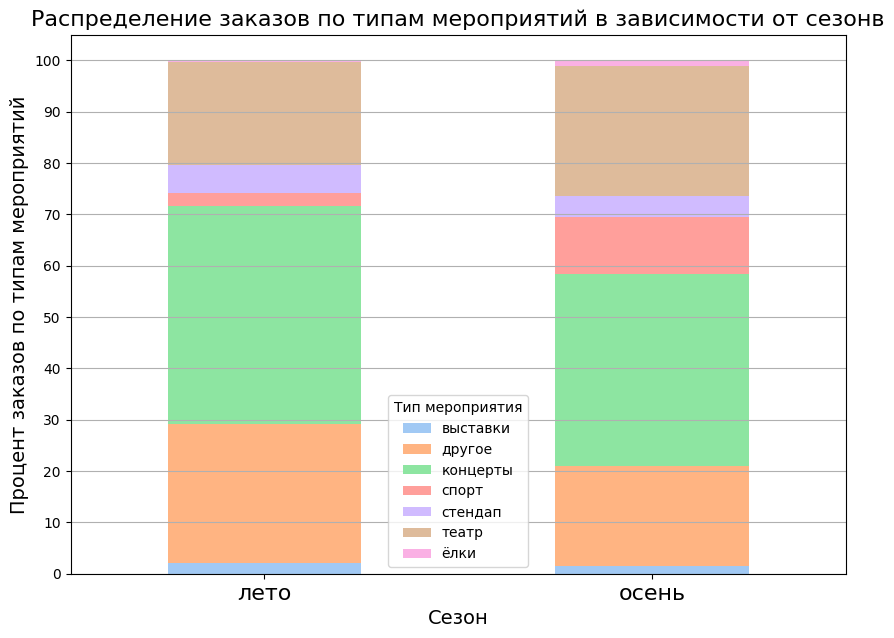

In [138]:
ss = season_pivot.plot(kind = 'bar',
                        x = 'season',
                        stacked=True,
                        figsize=(10, 7),
                        color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xlabel('Сезон', fontsize=14)
plt.xticks(fontsize = 16)
plt.ylabel('Процент заказов по типам мероприятий', fontsize=14)
plt.yticks(np.arange(0, 110, step=10))
plt.title('Распределение заказов по типам мероприятий в зависимости от сезонв', fontsize=16)
plt.grid(axis='y')
plt.legend(title='Тип мероприятия')

plt.show()

Летом наблюдается повышенный (по отношению к осени) спрос на мероприятия из категории "другое", осенью более популярны спорт, театр и ёлки, билеты на которые покупаются заранее.

In [139]:
device = final.groupby(['season', 'device_type_canonical']).agg({'order_id':'count'}).reset_index()
device['order_id %'] = device.groupby('season')['order_id'].transform(lambda x: round(100 * x / x.sum(), 2))
display(device)

,season,device_type_canonical,order_id,order_id %
0,лето,desktop,22923,19.31
1,лето,mobile,95767,80.69
2,осень,desktop,34303,20.35
3,осень,mobile,134232,79.65


In [140]:
device_pivot = pd.pivot_table(device, index='season', columns='device_type_canonical', values='order_id %').reset_index()
display(device_pivot)

device_type_canonical,season,desktop,mobile
0,лето,19.31,80.69
1,осень,20.35,79.65


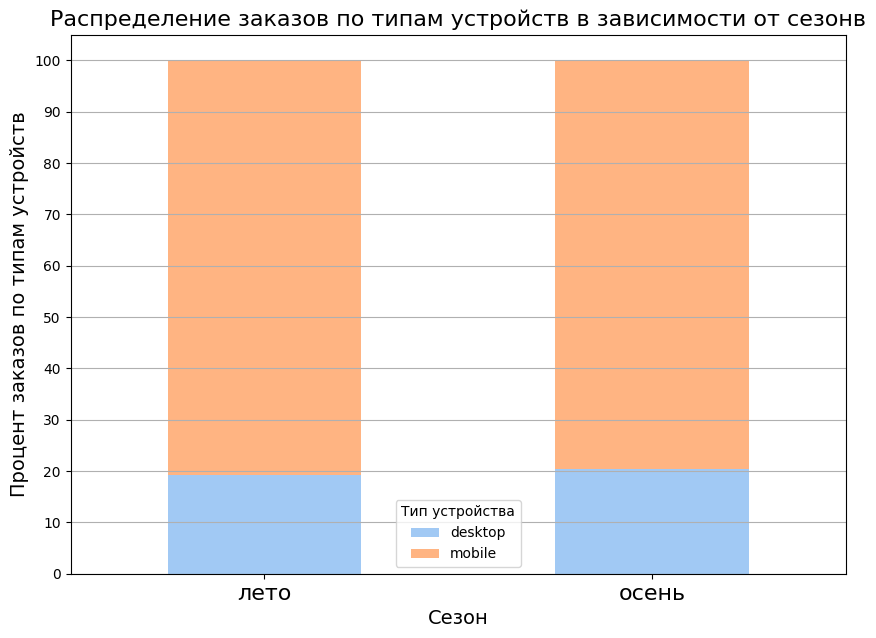

In [141]:
dev = device_pivot.plot(kind = 'bar',
                        x = 'season',
                        stacked=True,
                        figsize=(10, 7),
                        color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xlabel('Сезон', fontsize=14)
plt.xticks(fontsize = 16)
plt.ylabel('Процент заказов по типам устройств', fontsize=14)
plt.yticks(np.arange(0, 110, step=10))
plt.title('Распределение заказов по типам устройств в зависимости от сезонв', fontsize=16)
plt.grid(axis='y')
plt.legend(title='Тип устройства')

plt.show()

Распределение заказов, совершённых при помощи мобильных и стационарных устройств, не меняется в зависимости от сезона.

In [142]:
age = final.groupby(['season', 'age_limit']).agg({'order_id':'count'}).reset_index()
age['order_id %'] = age.groupby('season')['order_id'].transform(lambda x: round(100 * x / x.sum(), 2))
display(age)

,season,age_limit,order_id,order_id %
0,лето,0,21259,17.91
1,лето,6,21763,18.34
2,лето,12,24127,20.33
3,лето,16,33760,28.44
4,лето,18,17781,14.98
5,осень,0,39697,23.55
6,осень,6,29815,17.69
7,осень,12,37273,22.12
8,осень,16,44220,26.24
9,осень,18,17530,10.40


In [143]:
age_pivot = pd.pivot_table(age, index='season', columns='age_limit', values='order_id %').reset_index()
display(age_pivot)

age_limit,season,0,6,12,16,18
0,лето,17.91,18.34,20.33,28.44,14.98
1,осень,23.55,17.69,22.12,26.24,10.40


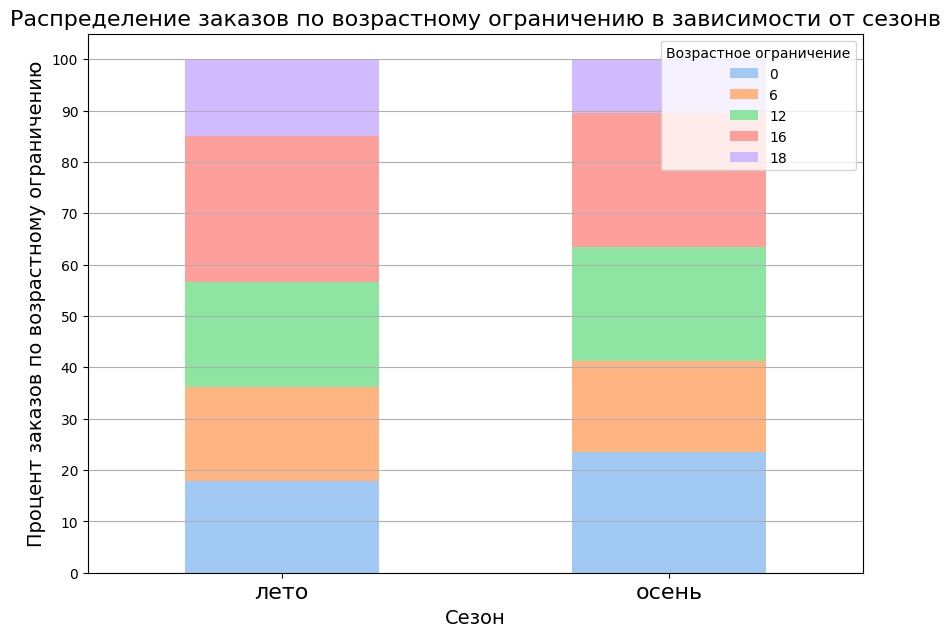

In [144]:
ag = age_pivot.plot(kind = 'bar',
                        x = 'season',
                        stacked=True,
                        figsize=(10, 7),
                        color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xlabel('Сезон', fontsize=14)
plt.xticks(fontsize = 16)
plt.ylabel('Процент заказов по возрастному ограничению', fontsize=14)
plt.yticks(np.arange(0, 110, step=10))
plt.title('Распределение заказов по возрастному ограничению в зависимости от сезонв', fontsize=16)
plt.grid(axis='y')
plt.legend(title='Возрастное ограничение')

plt.show()

Осенью наблюдается увеличение спроса на мероприятия с возрастным ограничением 0+ и уменьшение спроса на мероприятия 18+. Распределение остальных мероприятий остаётся приблизительно таким же, как и летом.

##### Выручка с одного билета
Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.

In [145]:
ses_rev = final.groupby(['season', 'event_type_main']).agg({'one_ticket_revenue_rub':'mean'}).reset_index()
display(ses_rev)

,season,event_type_main,one_ticket_revenue_rub
0,лето,выставки,86.715976
1,лето,другое,77.787910
2,лето,концерты,302.362973
3,лето,спорт,50.796611
4,лето,стендап,218.585918
5,лето,театр,214.445629
6,лето,ёлки,271.435421
7,осень,выставки,91.904871
8,осень,другое,76.430473
9,осень,концерты,269.341752


In [146]:
ses_rev_pivot = pd.pivot_table(ses_rev, index='event_type_main', columns='season', values='one_ticket_revenue_rub').reset_index()
display(ses_rev_pivot)

season,event_type_main,лето,осень
0,выставки,86.715976,91.904871
1,другое,77.787910,76.430473
2,концерты,302.362973,269.341752
3,спорт,50.796611,50.031848
4,стендап,218.585918,231.466943
5,театр,214.445629,176.240049
6,ёлки,271.435421,230.288701


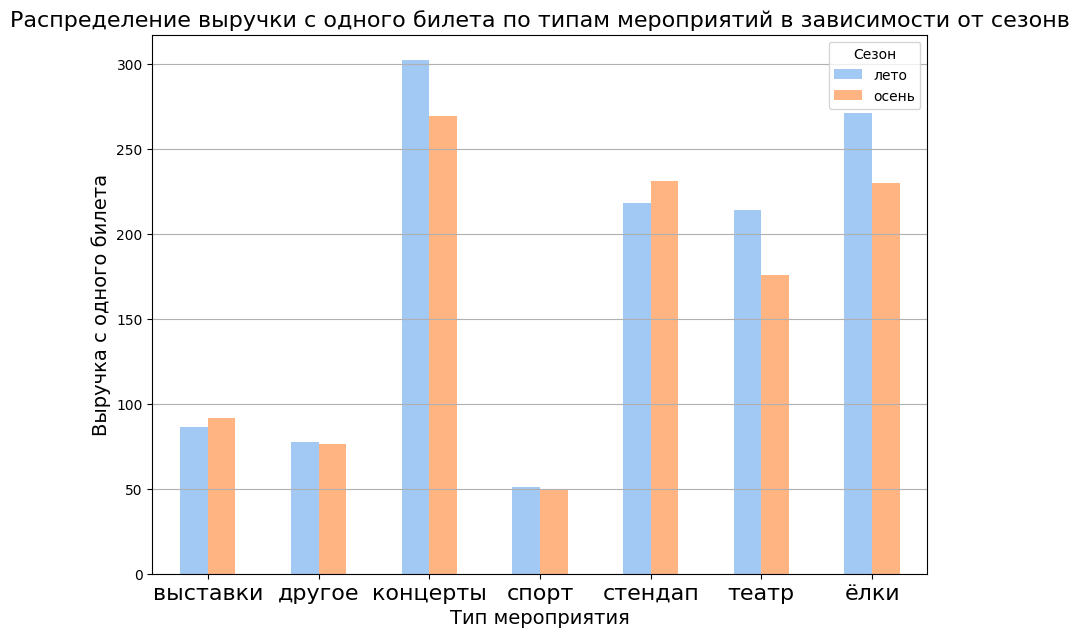

In [147]:
ssr = ses_rev_pivot.plot(kind = 'bar',
                        x = 'event_type_main',
                        figsize=(10, 7),
                        color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xlabel('Тип мероприятия', fontsize=14)
plt.xticks(fontsize = 16)
plt.ylabel('Выручка с одного билета', fontsize=14)
plt.title('Распределение выручки с одного билета по типам мероприятий в зависимости от сезонв', fontsize=16)
plt.grid(axis='y')
plt.legend(title='Сезон')

plt.show()

Средняя выручка с билетов на концерты, в театры и на ёлки снижается осенью, по остальным типам мероприятий выручка с одного билета примерно одинакова независимо от сезона.

Рассчитаем относительное изменение средней выручки с билетов.

In [148]:
ses_rev_pivot['change_%'] = round((ses_rev_pivot['осень'] - ses_rev_pivot['лето'])*100 / ses_rev_pivot['лето'], 2)
display(ses_rev_pivot)

season,event_type_main,лето,осень,change_%
0,выставки,86.715976,91.904871,5.98
1,другое,77.787910,76.430473,-1.75
2,концерты,302.362973,269.341752,-10.92
3,спорт,50.796611,50.031848,-1.51
4,стендап,218.585918,231.466943,5.89
5,театр,214.445629,176.240049,-17.82
6,ёлки,271.435421,230.288701,-15.16


Максимальное снижение выручки с билетов осенью наблюдается у билетов в театр (17,81%), на ёлки (15,16%) и на концерты (10,92%).

##### Промежуточный вывод

- Наблюдается увеличение количества заказов с июня по октябрь.
- Распределение заказов, совершённых при помощи мобильных и стационарных устройств, не меняется в зависимости от сезона.
- Осенью снижается спрос на мероприятия из категории "другое", но повышаются продажи билетов на спортивные мероприятия, театральные постановки и детские ёлки.
- Осенью наблюдается увеличение спроса на мероприятия с возрастным ограничением 0+ и уменьшение спроса на мероприятия 18+. Распределение остальных мероприятий остаётся приблизительно таким же, как и летом.
- Средняя выручка с билетов в театры, на ёлки и на концерты осенью снижается (на 17,81%, 15,16% и 10,92% соответственно), по остальным типам мероприятий выручка с одного билета остаётся примерно такой же, как летом.

#### Анализ осенней активности пользователей

Изучим активность пользователей осенью 2024 года.

##### Динамика по дням
Проанализируем динамику изменений по дням для:
   - общего числа заказов;
   - количества активных пользователей DAU;
   - среднего числа заказов на одного пользователя;
   - средней стоимости* одного билета.

In [149]:
fall = final.loc[final['season']=='осень']
fall_gr = fall.groupby('created_dt_msk').agg({'order_id':'count', 'user_id':'nunique', 'one_ticket_revenue_rub':'mean'}).reset_index()
fall_gr['orders_per_user'] = round(fall_gr['order_id']/fall_gr['user_id'], 2)
fall_gr['one_ticket_revenue_rub'] = round(fall_gr['one_ticket_revenue_rub'], 2)
display(fall_gr.head())

,created_dt_msk,order_id,user_id,one_ticket_revenue_rub,orders_per_user
0,2024-09-01,1331,565,201.68,2.36
1,2024-09-02,1376,573,190.02,2.40
2,2024-09-03,5095,777,80.80,6.56
3,2024-09-04,1760,683,179.66,2.58
4,2024-09-05,1938,739,190.29,2.62


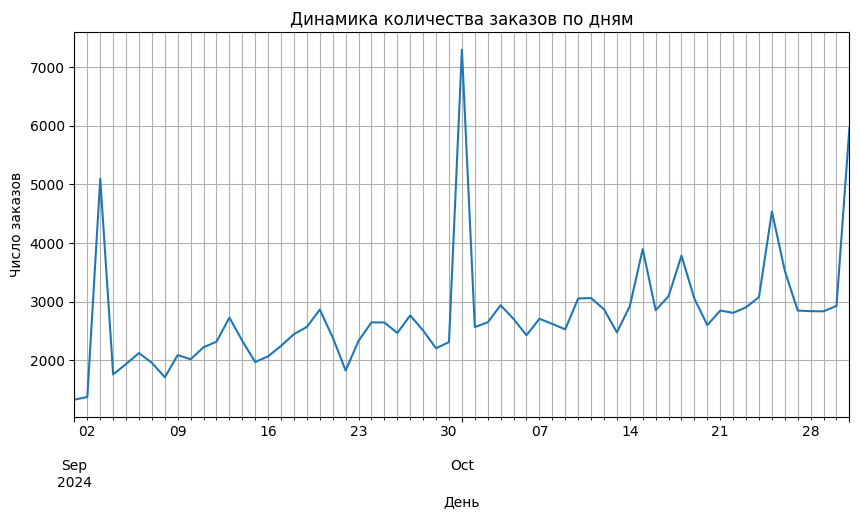

In [150]:
fall_gr.plot(
    kind='line',
    x='created_dt_msk',
    y='order_id',
    figsize = (10, 5),
    legend = False,
    title='Динамика количества заказов по дням'
)

plt.grid(which='both')
plt.xlabel('День')
plt.ylabel('Число заказов')
plt.show()

Наблюдается резкий рост числа заказов 1 октября, в целом число заказов в день демонстрирует тенденцию к увеличению.

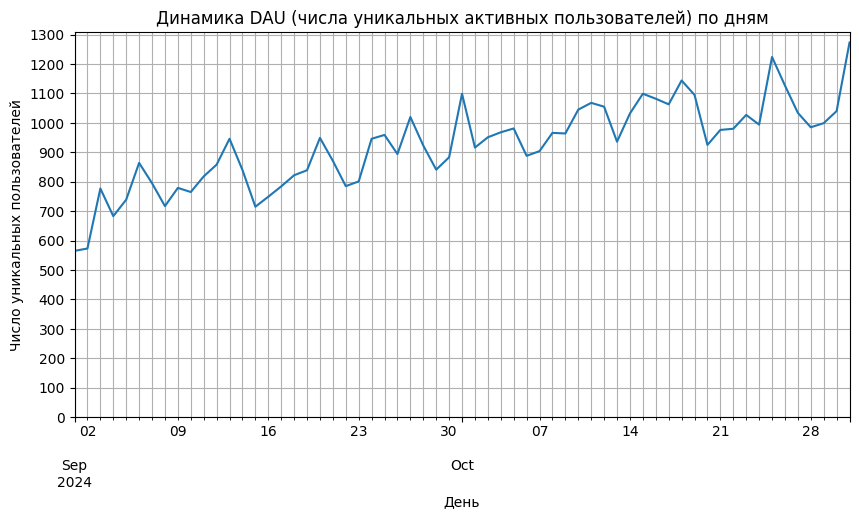

In [151]:
fall_gr.plot(
    kind='line',
    x='created_dt_msk',
    y='user_id',
    figsize = (10, 5),
    legend = False,
    title='Динамика DAU (числа уникальных активных пользователей) по дням'
)

plt.grid(which='both')
plt.yticks(np.arange(0, 1350, step=100))
plt.xlabel('День')
plt.ylabel('Число уникальных пользователей')
plt.show()

DAU также растёт в течение двух месяцев.

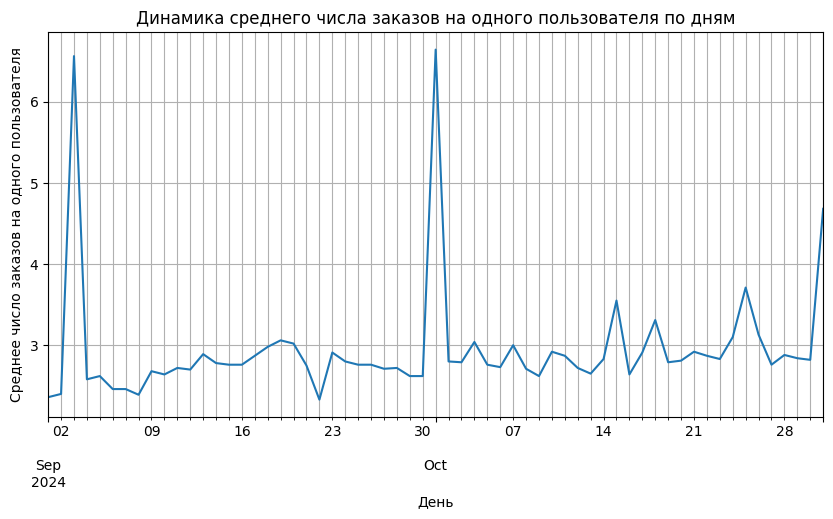

In [152]:
fall_gr.plot(
    kind='line',
    x='created_dt_msk',
    y='orders_per_user',
    figsize = (10, 5),
    legend = False,
    title='Динамика среднего числа заказов на одного пользователя по дням'
)

plt.grid(which='both')
plt.xlabel('День')
plt.ylabel('Среднее число заказов на одного пользователя')
plt.show()

Динамика среднего числа заказов на одного пользователя демонстрирует значительные пики 3 сентября и 1 октября, в целом можно наблюдать тенденцию к незначительному повышению этого показателя.

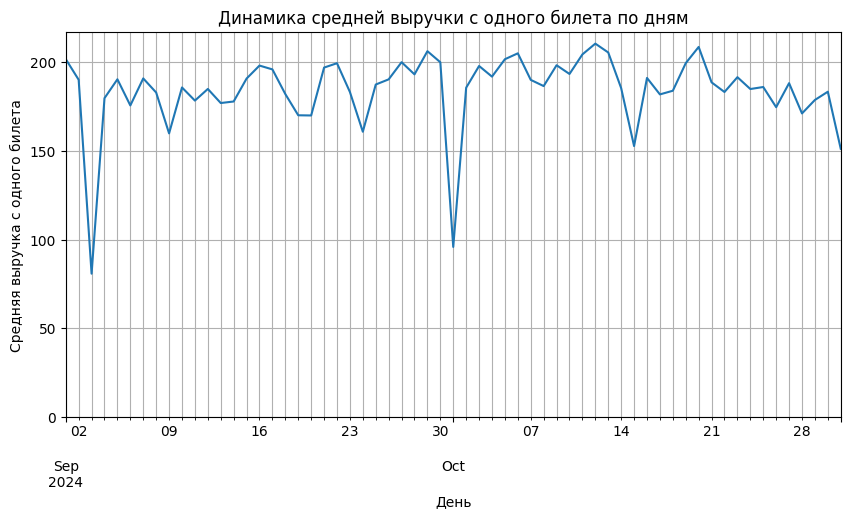

In [153]:
fall_gr.plot(
    kind='line',
    x='created_dt_msk',
    y='one_ticket_revenue_rub',
    figsize = (10, 5),
    legend = False,
    title='Динамика средней выручки с одного билета по дням'
)

plt.grid(which='both')
plt.yticks(np.arange(0, 220, step=50))
plt.xlabel('День')
plt.ylabel('Средняя выручка с одного билета')
plt.show()

Средняя выручка с одного билета была низкой 3 сентября и 1 октября (если на билеты были скидки, этим может объясняться рост среднего количества заказов на человека; однако возможно и обратная ситуация, когда клиенты делали много заказов, например, в связи с открытием продаж на мероприятие или получением зарплаты, но выбирали при этом недорогие билеты).

Тенденции к значительному изменению этого показателя в течение сентября-октября не наблюдается.

##### Недельная цикличность
Сравним пользовательскую активность в будни и выходные.

Для этого снова проанализируем динамику изменений, но теперь с агрегацией по дням недели, для:
   - общего числа заказов;
   - количества активных пользователей DAU;
   - среднего числа заказов на одного пользователя;
   - средней стоимости* одного билета.

In [154]:
fall_gr['weekday'] = pd.DatetimeIndex(fall_gr['created_dt_msk']).weekday + 1
fall_gr = fall_gr.sort_values(by='weekday')
display(fall_gr.head())

,created_dt_msk,order_id,user_id,one_ticket_revenue_rub,orders_per_user,weekday
1,2024-09-02,1376,573,190.02,2.40,1
8,2024-09-09,2091,779,159.82,2.68,1
15,2024-09-16,2070,749,198.02,2.76,1
22,2024-09-23,2334,801,183.13,2.91,1
29,2024-09-30,2312,883,199.89,2.62,1


In [155]:
fall_gr_gr = fall_gr.groupby('weekday').agg({'order_id':'mean', 'user_id':'mean', 'orders_per_user':'mean', 'one_ticket_revenue_rub':'mean'}).reset_index()

fall_gr_gr['order_id'] = round(fall_gr_gr['order_id'], 2)
fall_gr_gr['user_id'] = round(fall_gr_gr['user_id'], 2)
fall_gr_gr['orders_per_user'] = round(fall_gr_gr['orders_per_user'], 2)
fall_gr_gr['one_ticket_revenue_rub'] = round(fall_gr_gr['one_ticket_revenue_rub'], 2)
display(fall_gr_gr)

,weekday,order_id,user_id,orders_per_user,one_ticket_revenue_rub
0,1,2389.56,853.56,2.78,185.09
1,2,3497.11,935.00,3.72,157.76
2,3,2540.44,923.44,2.75,186.32
3,4,3014.67,961.78,3.06,182.69
4,5,3101.50,1022.88,3.00,186.02
5,6,2668.00,960.88,2.76,193.05
6,7,2155.89,822.89,2.60,198.62


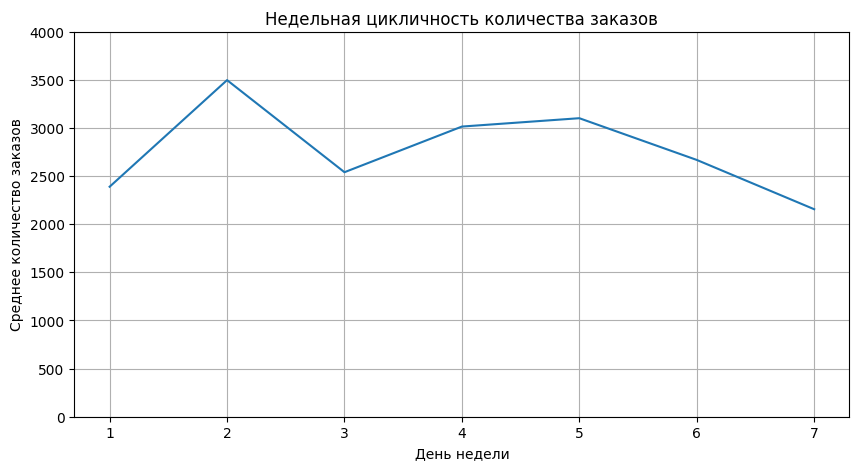

In [156]:
fall_gr_gr.plot(
    kind='line',
    x='weekday',
    y='order_id',
    figsize = (10, 5),
    legend = False,
    title='Недельная цикличность количества заказов'
)

plt.grid(which='both')
plt.yticks(np.arange(0, 4500, step=500))
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.show()

Наибольшее среднее число заказов приходится на вторник. Это коррелирует с данными за 3 сентября и 1 октября (это вторники). В среду, субботу, воскресенье и понедельник значения самые низкие.

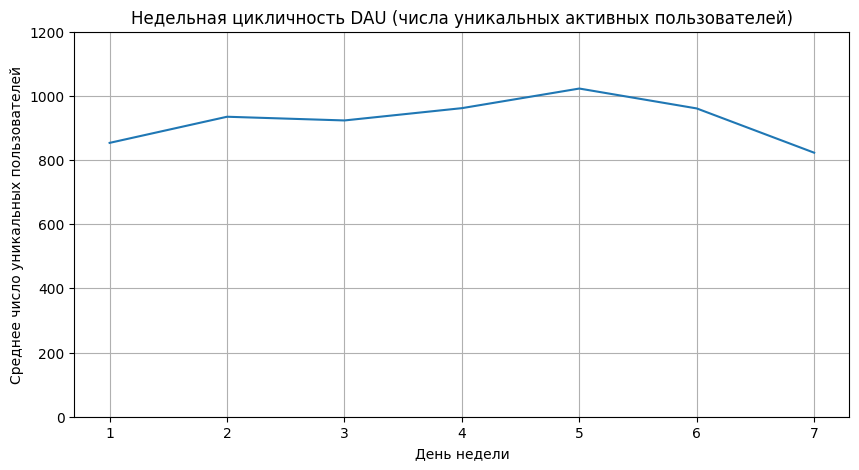

In [157]:
fall_gr_gr.plot(
    kind='line',
    x='weekday',
    y='user_id',
    figsize = (10, 5),
    legend = False,
    title='Недельная цикличность DAU (числа уникальных активных пользователей)'
)

plt.grid(which='both')
plt.yticks(np.arange(0, 1400, step=200))
plt.xlabel('День недели')
plt.ylabel('Среднее число уникальных пользователей')
plt.show()

Наибольшее значение DAU наблюдается в пятницу, далее идёт снижение к воскресенью и понедельнику, затем снова рост.

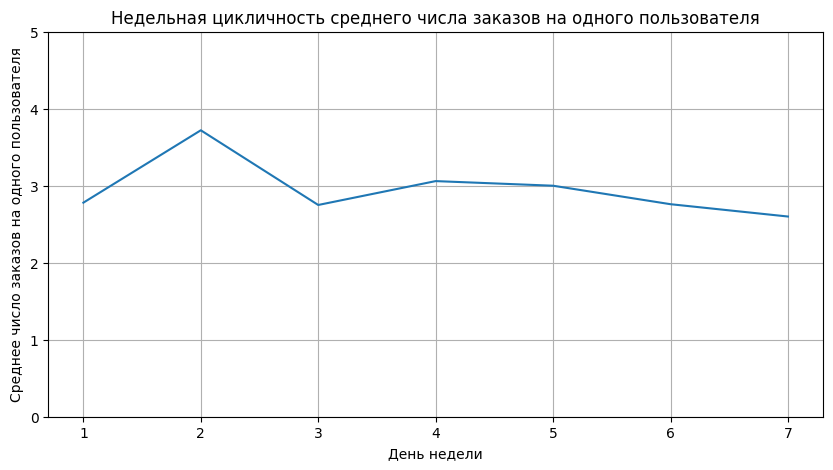

In [158]:
fall_gr_gr.plot(
    kind='line',
    x='weekday',
    y='orders_per_user',
    figsize = (10, 5),
    legend = False,
    title='Недельная цикличность среднего числа заказов на одного пользователя'
)

plt.grid(which='both')
plt.yticks(np.arange(0, 6))
plt.xlabel('День недели')
plt.ylabel('Среднее число заказов на одного пользователя')
plt.show()

Наибольшее среднее число заказов на одного пользователя, так же как и среднее число заказов, наблюдается по вторникам. Это коррелирует с данными за 3 сентября и 1 октября.

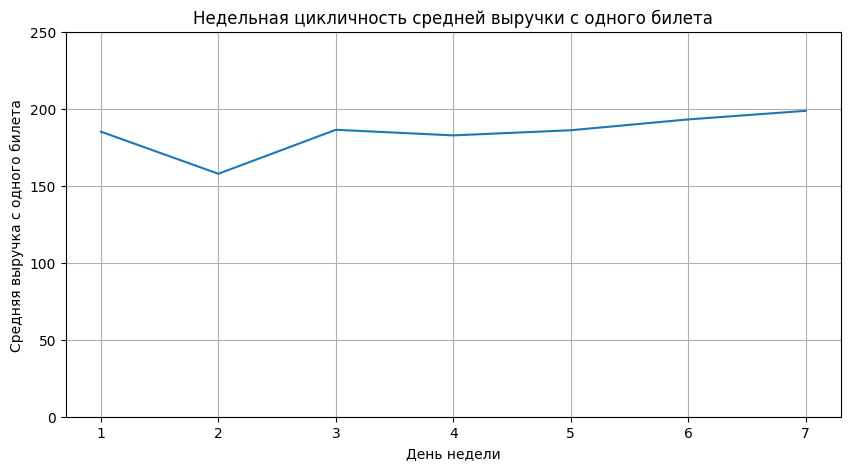

In [159]:
fall_gr_gr.plot(
    kind='line',
    x='weekday',
    y='one_ticket_revenue_rub',
    figsize = (10, 5),
    legend = False,
    title='Недельная цикличность средней выручки с одного билета'
)

plt.grid(which='both')
plt.yticks(np.arange(0, 260, step=50))
plt.xlabel('День недели')
plt.ylabel('Средняя выручка с одного билета')
plt.show()

Наиболее низкая средняя цена билета также приходится на вторники. Это коррелирует с данными за 3 сентября и 1 октября.

Имеет смысл проверить, чем были вызваны резкие изменения в активности клиентов 3 сентября и 1 октября, поскольку данные за эти два дня существенно повлияли на недельную динамику показателей.
Возможно, стоило бы построить дополнительные визуализации без учёта этих двух дней (например, заменив значения за соответствующие даты усреднёнными значениями за неделю или месяц), чтобы оценить масштаб влияния этих выбросов.

##### Промежуточный вывод

Динамика по дням в сентябре-октябре 2024 года:
- Наблюдается резкий рост числа заказов 1 октября, в целом число заказов в день демонстрирует тенденцию к увеличению.
- Число уникальных активных пользователей (DAU) также растёт в течение двух месяцев.
- Динамика среднего числа заказов на одного пользователя демонстрирует значительные пики 3 сентября и 1 октября, в целом можно наблюдать тенденцию к незначительному повышению этого показателя.
- Средняя выручка с одного билета была низкой 3 сентября и 1 октября (если на билеты были скидки, этим может объясняться рост среднего количества заказов на человека; однако возможно и обратная ситуация, когда клиенты делали много заказов, например, в связи с открытием продаж на мероприятие или получением зарплаты, но выбирали при этом недорогие билеты). Тенденции к значительному изменению этого показателя в течение сентября-октября не наблюдается.

Динамика по дням недели в указанном периоде:
- Наибольшее среднее число заказов приходится на вторник. Это коррелирует с данными за 3 сентября и 1 октября (это вторники). В среду, субботу, воскресенье и понедельник значения самые низкие.
- С понедельника по пятницу наблюдается рост DAU, в пятницу значение максимально, далее идёт снижение к воскресенью и понедельнику.
- Наибольшее среднее число заказов на одного пользователя наблюдается по вторникам. Это также коррелирует с данными за 3 сентября и 1 октября.
- Наиболее низкая выручка с одного билета также приходится на вторники. Это коррелирует с данными за 3 сентября и 1 октября.

Рекомендации:
- Дополнительно проверить, чем были вызваны резкие изменения в активности клиентов 3 сентября и 1 октября, поскольку данные за эти два дня существенно повлияли на недельную динамику показателей.

#### Выявление популярных событий и партнёров

Изучим, как события распределены по регионам и партнёрам. Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

##### Аналитика по регионам
Для каждого региона рассчитаем уникальное количество мероприятий и общее число заказов. Оценим, в каких регионах предлагается наибольшее разнообразие мероприятий.

Сгруппируем данные по типам мероприятий и подсчитаем число мероприятий каждого типа в разных регионах.

In [160]:
ev_reg_type = final.groupby(['event_type_main', 'region_name']).agg({'order_id':'count'}).reset_index()
ev_reg_type = ev_reg_type.groupby('event_type_main').apply(lambda g: g.sort_values('order_id', ascending = False)).reset_index(drop=True)
display(ev_reg_type.head())

C:\Users\koula\AppData\Local\Temp\ipykernel_34692\3886121707.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ev_reg_type = ev_reg_type.groupby('event_type_main').apply(lambda g: g.sort_values('order_id', ascending = False)).reset_index(drop=True)


,event_type_main,region_name,order_id
0,выставки,Каменевский регион,2517
1,выставки,Североярская область,1220
2,выставки,Солнечноземская область,275
3,выставки,Светополянский округ,149
4,выставки,Речиновская область,125


Выделим топ-3 регионов по количеству событий каждого типа.

In [161]:
ev_reg_type_3 = ev_reg_type.groupby('event_type_main').apply(lambda x: x.nlargest(3, 'order_id')).reset_index(drop=True)
ev_reg_type_3['reg_3_cnt'] = ev_reg_type_3.groupby('region_name')['order_id'].transform(lambda x: x.count())
display(ev_reg_type_3.head())

C:\Users\koula\AppData\Local\Temp\ipykernel_34692\1079079825.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ev_reg_type_3 = ev_reg_type.groupby('event_type_main').apply(lambda x: x.nlargest(3, 'order_id')).reset_index(drop=True)


,event_type_main,region_name,order_id,reg_3_cnt
0,выставки,Каменевский регион,2517,7
1,выставки,Североярская область,1220,6
2,выставки,Солнечноземская область,275,1
3,другое,Каменевский регион,18943,7
4,другое,Североярская область,11256,6


В поле `reg_3_cnt` содержится значение, показывающее, сколько раз регион попадал в топ-3. Это позволяет нам выделить лидеров по разнообразию мероприятий.

In [162]:
reg_3 = ev_reg_type_3[['region_name', 'reg_3_cnt']]
reg_3 = reg_3.groupby('region_name').agg({'reg_3_cnt':'unique'}).sort_values('reg_3_cnt').reset_index()
reg_3['reg_3_cnt'] = reg_3['reg_3_cnt'].astype('int')
display(reg_3)

,region_name,reg_3_cnt
0,Медовская область,1
1,Озернинский край,1
2,Солнечноземская область,1
3,Чистогорская область,1
4,Широковская область,4
5,Североярская область,6
6,Каменевский регион,7


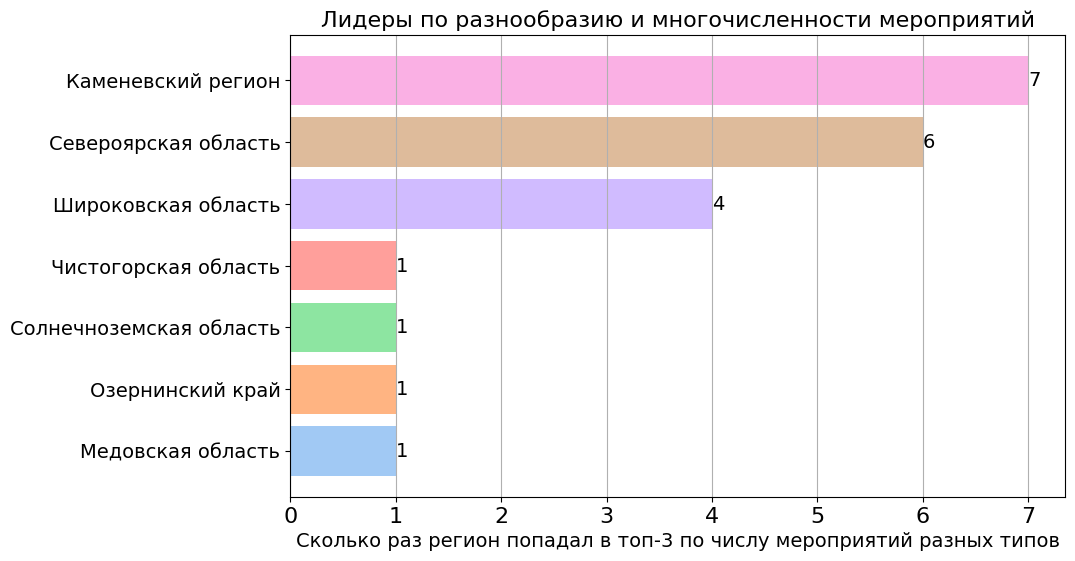

In [163]:
plt.figure(figsize=(10, 6))

reg = plt.barh(
             reg_3['region_name'],
             reg_3['reg_3_cnt'],
             color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)
plt.xlabel('Сколько раз регион попадал в топ-3 по числу мероприятий разных типов', fontsize=14)
plt.title('Лидеры по разнообразию и многочисленности мероприятий', fontsize=16)
plt.grid(axis='x')

for bar in reg:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width()}', ha='left', va='center', fontsize=14)

plt.show()

Итак, в абсолютных лидерах по разнообразию и количеству проводимых мероприятий - Каменевский район (в топ-3 по 7 типам мероприятий), Североярская область (в топ-3 по 6 типам мероприятий) и Широковская область (в топ-3 по 4 типам мероприятий).

##### Аналитика по типам мероприятий

Теперь определим, какие типы мероприятий наиболее характерны для разных регионов.

In [164]:
ev_reg = final.groupby(['region_name', 'event_type_main']).agg({'order_id':'count'}).reset_index()
display(ev_reg.head())

,region_name,event_type_main,order_id
0,Белоярская область,другое,25
1,Белоярская область,концерты,88
2,Белоярская область,стендап,5
3,Белоярская область,театр,80
4,Белоярская область,ёлки,1


In [165]:
ev_reg['order_id_%'] = ev_reg.groupby('region_name')['order_id'].transform(lambda x: round(100 * x / x.sum(), 2))
display(ev_reg.head())

,region_name,event_type_main,order_id,order_id_%
0,Белоярская область,другое,25,12.56
1,Белоярская область,концерты,88,44.22
2,Белоярская область,стендап,5,2.51
3,Белоярская область,театр,80,40.20
4,Белоярская область,ёлки,1,0.50


Оставим для каждого региона топ-3 типов проводимых мероприятий (по доле от общего числа проводимых в регионе мероприятий).

In [166]:
ev_reg_3 = ev_reg.groupby('region_name').apply(lambda x: x.nlargest(3, 'order_id_%')).reset_index(drop=True)
ev_reg_3['ev_3_cnt'] = ev_reg_3.groupby('event_type_main')['region_name'].transform(lambda x: x.count())
display(ev_reg_3.head())

C:\Users\koula\AppData\Local\Temp\ipykernel_34692\3798389018.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ev_reg_3 = ev_reg.groupby('region_name').apply(lambda x: x.nlargest(3, 'order_id_%')).reset_index(drop=True)


,region_name,event_type_main,order_id,order_id_%,ev_3_cnt
0,Белоярская область,концерты,88,44.22,78
1,Белоярская область,театр,80,40.20,56
2,Белоярская область,другое,25,12.56,77
3,Берестовский округ,концерты,323,82.19,78
4,Берестовский округ,театр,63,16.03,56


В поле `ev_3_cnt` - количество регионов, для которых данный тип мероприятия попадал в топ-3.

In [167]:
ev_3 = ev_reg_3.groupby('event_type_main').agg({'ev_3_cnt':'unique'}).sort_values('ev_3_cnt').reset_index()
ev_3['ev_3_cnt'] = ev_3['ev_3_cnt'].astype('int')
display(ev_3)

,event_type_main,ev_3_cnt
0,выставки,1
1,стендап,8
2,спорт,13
3,театр,56
4,другое,77
5,концерты,78


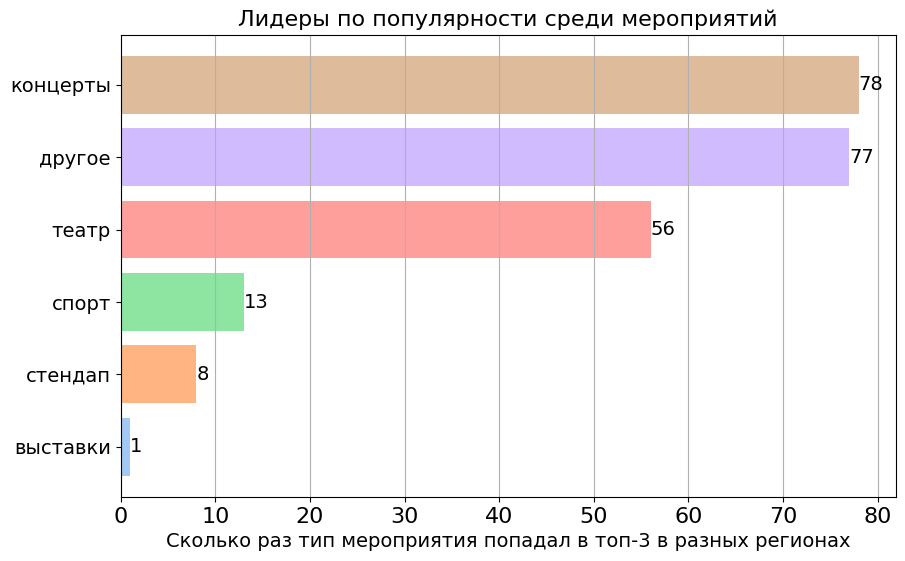

In [168]:
plt.figure(figsize=(10, 6))

ev = plt.barh(
             ev_3['event_type_main'],
             ev_3['ev_3_cnt'],
             color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)
plt.xlabel('Сколько раз тип мероприятия попадал в топ-3 в разных регионах', fontsize=14)
plt.title('Лидеры по популярности среди мероприятий', fontsize=16)
plt.grid(axis='x')

for bar in ev:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width()}', ha='left', va='center', fontsize=14)

plt.show()

В абсолютных лидерах по популярности - концерты, категория "другое" и театральные постановки.

##### Аналитика по партнёрам
Для каждого билетного партнёра подсчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. Выделим наиболее активных партнёров.

In [169]:
part = final.groupby('service_name').agg({'event_id':'nunique', 'order_id':'count', 'revenue_rub':'sum'}).reset_index()
display(part.head())

,service_name,event_id,order_id,revenue_rub
0,Crazy ticket!,256,789,451924.80
1,Show_ticket,295,2091,1451899.37
2,Билет по телефону,20,85,72447.40
3,Билеты без проблем,4205,62719,24736375.24
4,Билеты в интернете,1,4,548.23


Определим топ-5 партнёров по числу мероприятий, на которые были проданы билеты.

In [170]:
part_ev_5 = part.nlargest(5, 'event_id', keep='all').reset_index(drop=True)
display(part_ev_5)

,service_name,event_id,order_id,revenue_rub
0,Лови билет!,4862,40787,16729423.63
1,Билеты без проблем,4205,62719,24736375.24
2,Билеты в руки,3517,40189,13200590.47
3,Облачко,2335,26410,18609295.34
4,Лучшие билеты,1755,17708,2721016.63


In [171]:
part_ev_5 = part_ev_5.sort_values('event_id')

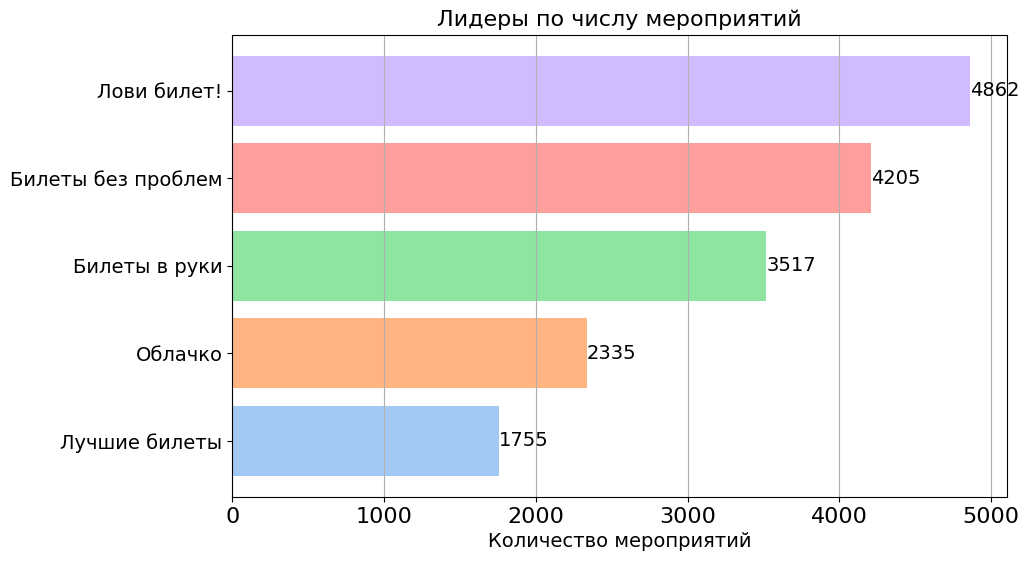

In [172]:
plt.figure(figsize=(10, 6))

prt = plt.barh(
             part_ev_5['service_name'],
             part_ev_5['event_id'],
             color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)
plt.xlabel('Количество мероприятий', fontsize=14)
plt.title('Лидеры по числу мероприятий', fontsize=16)
plt.grid(axis='x')

for bar in prt:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width()}', ha='left', va='center', fontsize=14)

plt.show()

Топ-5 партнёров по количеству мероприятий:
- "Лови билет!"
- "Билеты без проблем"
- "Билеты в руки"
- "Облачко"
- "Лучшие билеты".

Определим топ-5 партнёров по количеству обработанных заказов.

In [173]:
part_t_5 = part.nlargest(5, 'order_id', keep='all').reset_index(drop=True)
part_t_5['revenue_rub'] = round(part_t_5['revenue_rub'])
display(part_t_5)

,service_name,event_id,order_id,revenue_rub
0,Билеты без проблем,4205,62719,24736375.0
1,Лови билет!,4862,40787,16729424.0
2,Билеты в руки,3517,40189,13200590.0
3,Мой билет,1297,34116,21038048.0
4,Облачко,2335,26410,18609295.0


In [174]:
part_t_5 = part_t_5.sort_values('order_id')

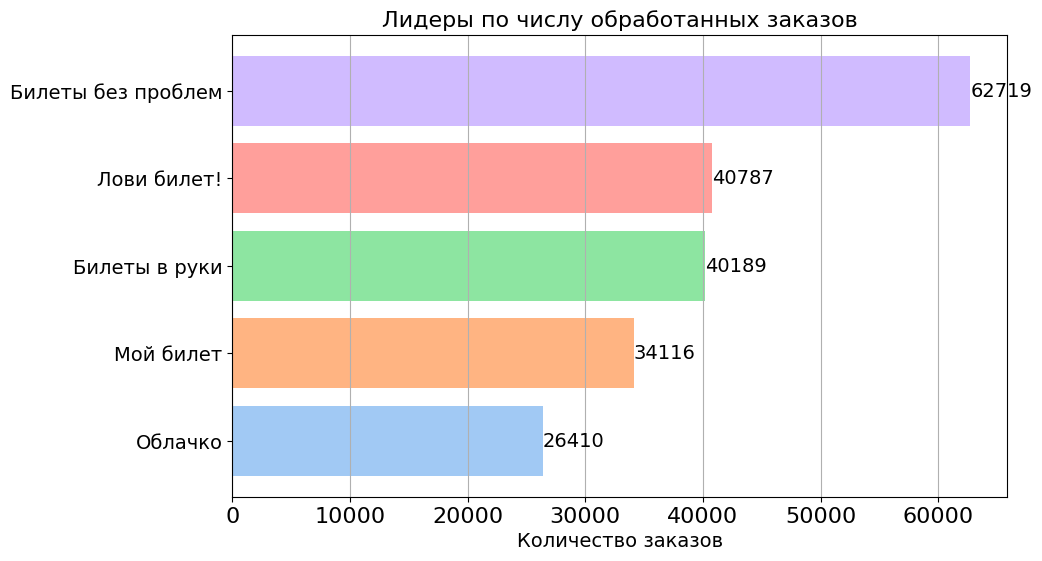

In [175]:
plt.figure(figsize=(10, 6))

prtt = plt.barh(
             part_t_5['service_name'],
             part_t_5['order_id'],
             color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)
plt.xlabel('Количество заказов', fontsize=14)
plt.title('Лидеры по числу обработанных заказов', fontsize=16)
plt.grid(axis='x')

for bar in prtt:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width()}', ha='left', va='center', fontsize=14)

plt.show()

Топ-5 партнёров по количеству мероприятий:
- "Билеты без проблем"
- "Лови билет!"
- "Билеты в руки"
- "Мой билет"
- "Облачко".

Определим топ-5 партнёров по выручке.

In [176]:
part_r_5 = part.nlargest(5, 'revenue_rub', keep='all').reset_index(drop=True)
part_r_5['revenue_rub'] = round(part_r_5['revenue_rub'])
part_r_5['revenue_rub_mln'] = round(part_r_5['revenue_rub']/1000000, 2)
part_r_5 = part_r_5.sort_values('revenue_rub_mln')
display(part_r_5)

,service_name,event_id,order_id,revenue_rub,revenue_rub_mln
4,Весь в билетах,856,16438,16566881.0,16.57
3,Лови билет!,4862,40787,16729424.0,16.73
2,Облачко,2335,26410,18609295.0,18.61
1,Мой билет,1297,34116,21038048.0,21.04
0,Билеты без проблем,4205,62719,24736375.0,24.74


Топ-5 партнёров по количеству мероприятий:
- "Билеты без проблем"
- "Мой билет"
- "Облачко"
- "Лови билет!"
- "Весь в билетах"

Определим, сколько раз партнёры входили в топ-5 по различным параметрам, чтобы определить наиболее активных.

In [177]:
part_top = pd.concat([part_ev_5['service_name'], part_t_5['service_name'], part_r_5['service_name']]).reset_index()
display(part_top)

,index,service_name
0,4,Лучшие билеты
1,3,Облачко
2,2,Билеты в руки
3,1,Билеты без проблем
4,0,Лови билет!
5,4,Облачко
6,3,Мой билет
7,2,Билеты в руки
8,1,Лови билет!
9,0,Билеты без проблем


In [178]:
part_top['cnt'] = part_top.groupby('service_name').transform(lambda x: x.count())
display(part_top)

,index,service_name,cnt
0,4,Лучшие билеты,1
1,3,Облачко,3
2,2,Билеты в руки,2
3,1,Билеты без проблем,3
4,0,Лови билет!,3
5,4,Облачко,3
6,3,Мой билет,2
7,2,Билеты в руки,2
8,1,Лови билет!,3
9,0,Билеты без проблем,3


In [179]:
part_top_pivot = pd.pivot_table(part_top, index='service_name', values='cnt').reset_index()
part_top_pivot = part_top_pivot.sort_values('cnt')
display(part_top_pivot)

,service_name,cnt
2,Весь в билетах,1.0
4,Лучшие билеты,1.0
5,Мой билет,2.0
1,Билеты в руки,2.0
3,Лови билет!,3.0
0,Билеты без проблем,3.0
6,Облачко,3.0


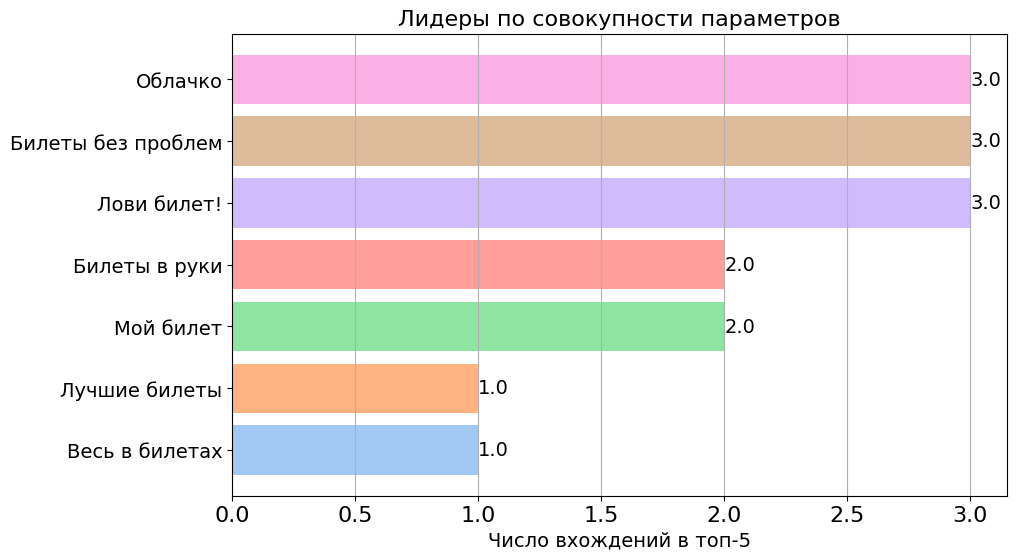

In [180]:
plt.figure(figsize=(10, 6))

pv = plt.barh(
             part_top_pivot['service_name'],
             part_top_pivot['cnt'],
             color=sns.color_palette('pastel')
)

plt.xticks(rotation=0)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)
plt.xlabel('Число вхождений в топ-5', fontsize=14)
plt.title('Лидеры по совокупности параметров', fontsize=16)
plt.grid(axis='x')

for bar in pv:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width()}', ha='left', va='center', fontsize=14)

plt.show()

Абсолютными лидерами являются "Облачко", "Лови билет!" и "Билеты без проблем", которые вошли в топ-5 по всем трём исследованным параметрам.

##### Промежуточный вывод

- Лидерами по разнообразию и общему количеству проводимых мероприятий являются Каменевский район (в топ-3 по 7 типам мероприятий), Североярская область (в топ-3 по 6 типам мероприятий) и Широковская область (в топ-3 по 4 типам мероприятий).
- В целом наиболее популярны концерты, мероприятия из категории "другое" и театральные постановки.
- Абсолютными лидерами по совокупности параметров являются партнёры "Облачко", "Лови билет!" и "Билеты без проблем".

### Статистический анализ данных за осенний период

Выдвинуты две гипотезы относительно поведения пользователей в сентябре-октябре 2024 года:

- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Проверим каждую из них при помощи статистического анализа.

#### Среднее количество заказов

In [181]:
final_aut = final.loc[final['season'] == 'осень'].reset_index()

In [182]:
fn_or = final_aut.groupby(['user_id', 'device_type_canonical']).agg({'order_id':'count'}).reset_index()
display(fn_or.describe())
display(fn_or.head())

,order_id
count,19056.000000
mean,8.844196
std,61.437968
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,4328.000000


,user_id,device_type_canonical,order_id
0,0005ca5e93f2cf4,mobile,1
1,000898990054619,mobile,2
2,000a55a418c128c,mobile,2
3,001e7037d013f0f,mobile,2
4,00245c702bc343e,mobile,2


Наблюдаются заметные выбросы в числе заказов на одного пользователя. Возьмём 99-й процентиль от этого значения.

In [183]:
fn_or_99 = fn_or.loc[fn_or['order_id'] <=  np.percentile(fn_or['order_id'], 99)]
display(fn_or_99.describe())

,order_id
count,18866.000000
mean,5.015266
std,10.279450
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,112.000000


112 заказов с одного пользователя тоже многовато за 61 день, попробуем 95-й процентиль.

In [184]:
fn_or_95 = fn_or.loc[fn_or['order_id'] <=  np.percentile(fn_or['order_id'], 95)]
display(fn_or_95.describe())

,order_id
count,18125.000000
mean,3.296883
std,3.851164
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,23.000000


Выходит максимум в 23 заказа за 2 месяца. Оставим это значение.

Oценим число пользователей, совершавших заказы и с мобильных, и со стационарных устройств.

In [185]:
fin_mob = fn_or_95.loc[fn_or_95['device_type_canonical'] == 'mobile']
fin_des = fn_or_95.loc[fn_or_95['device_type_canonical'] == 'desktop']
fin_mob_gr = fin_mob.groupby(['user_id', 'device_type_canonical']).agg({'order_id':'sum'})
fin_des_gr = fin_des.groupby(['user_id', 'device_type_canonical']).agg({'order_id':'sum'})
fin_m = pd.merge(fin_mob_gr, fin_des_gr, on = 'user_id', suffixes=('_mob', '_desk'), how = 'inner').reset_index()
display(fin_m.head())

print(f'''Общее число пользователей: {fn_or_95['user_id'].nunique()}.''')
print(f'''Число пользователей двух видов устройств: {fin_m.shape[0]}.''')
print(f'''Доля пользователей двух видов устройств: {round(fin_m.shape[0] * 100 / fn_or_95['user_id'].nunique(), 2)}%.''')

,user_id,order_id_mob,order_id_desk
0,0028d17a676f8c8,1,1
1,002b75ca606ba46,1,3
2,002ec276eee9b0b,11,1
3,005fefeabf1e678,1,3
4,009201290d7316b,14,1


Общее число пользователей: 15565.
Число пользователей двух видов устройств: 2560.
Доля пользователей двух видов устройств: 16.45%.


Исключим пользователей, которые делали заказы с обоих типов устройств.

In [186]:
filter = fin_m['user_id']
fn_filtered = fn_or_95.loc[~fn_or_95['user_id'].isin(filter)].reset_index()
display(fn_filtered.head())
display(fn_filtered.info())
display(fn_filtered['order_id'].describe())

,index,user_id,device_type_canonical,order_id
0,0,0005ca5e93f2cf4,mobile,1
1,1,000898990054619,mobile,2
2,2,000a55a418c128c,mobile,2
3,3,001e7037d013f0f,mobile,2
4,4,00245c702bc343e,mobile,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13005 entries, 0 to 13004
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   index                  13005 non-null  int64 
 1   user_id                13005 non-null  object
 2   device_type_canonical  13005 non-null  object
 3   order_id               13005 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 406.5+ KB


None

count    13005.000000
mean         2.775163
std          3.202013
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         23.000000
Name: order_id, dtype: float64

Сравним размеры групп.

In [187]:
av_or = fn_filtered.groupby('device_type_canonical').agg({'user_id':'nunique', 'order_id':'sum'}).reset_index()
av_or['order_per_user'] = round(av_or['order_id'] / av_or['user_id'], 2)

display(av_or)

stdev = round(fn_filtered['order_id'].std(), 2)
print(f'''Стандартное отклонение для обеих групп: {stdev}.''')

mx = av_or['user_id'].max()
mn = av_or['user_id'].min()
print(f'''Размеры групп отличаются в {round(mx/mn, 1)} р.''')

,device_type_canonical,user_id,order_id,order_per_user
0,desktop,2102,6844,3.26
1,mobile,10903,29247,2.68


Стандартное отклонение для обеих групп: 3.2.
Размеры групп отличаются в 5.2 р.


Обратим внимание, что при расчётах для всех пользователей, включая тех, кто делал заказы с обоих типов устройств, средние значения числа заказов на каждого пользователя отличаются от полученных выше, однако пользователей с двумя устройствами мы исключили.

In [188]:
av_or_95 = fn_or_95.groupby('device_type_canonical').agg({'user_id':'nunique', 'order_id':'sum'}).reset_index()
av_or_95['order_per_user'] = round(av_or_95['order_id'] / av_or_95['user_id'], 2)

print(f'''Данные по всем пользователям (95 процентиль, независимо от количества
использованных типов устройств):''')
display(av_or_95)

stdev_95 = round(fn_or_95['order_id'].std(), 2)
print(f'''Стандартное отклонение для обеих групп: {stdev_95}.''')

mx_95 = av_or_95['user_id'].max()
mn_95 = av_or_95['user_id'].min()
print(f'''Размеры групп отличаются в {round(mx_95/mn_95, 1)} р.''')

Данные по всем пользователям (95 процентиль, независимо от количества
использованных типов устройств):


,device_type_canonical,user_id,order_id,order_per_user
0,desktop,4662,14137,3.03
1,mobile,13463,45619,3.39


Стандартное отклонение для обеих групп: 3.85.
Размеры групп отличаются в 2.9 р.


In [189]:
boxplot05 = fn_filtered.loc[fn_filtered['device_type_canonical']=='mobile'].boxplot(column='order_id',
                     vert=False,
                     color='black',
                     flierprops=dict(markerfacecolor='gold', markeredgecolor='grey', marker='o'),
                     medianprops=dict(color="red"),
                     figsize=(10, 4))
                            
boxplot05.set_title('Среднее число заказов на одного пользователя мобильного устройства')
boxplot05.set_xlabel('Среднее число заказов')
boxplot05.axes.get_yaxis().set_visible(False)

In [190]:
boxplot05 = fn_filtered.loc[(fn_filtered['device_type_canonical']=='mobile') &
                           (fn_filtered['order_id'] <= np.nanpercentile(fn_filtered.loc[fn_filtered['device_type_canonical']=='mobile']['order_id'], 95))].boxplot(column='order_id',
                     vert=False,
                     color='black',
                     flierprops=dict(markerfacecolor='gold', markeredgecolor='grey', marker='o'),
                     medianprops=dict(color="red"),
                     figsize=(10, 4))
                            
boxplot05.set_title('Среднее число заказов на одного пользователя мобильного устройства')
boxplot05.set_xlabel('Среднее число заказов')
boxplot05.axes.get_yaxis().set_visible(False)

Поскольку наблюдаются выбросы даже при учёте только 95-го процентиля, имеет смысл брать для анализа всю выборку и проводить тест Манна-Уитни.

Воспользуемся калькулятором https://www.benchmarksixsigma.com/calculators/sample-size-calculator-for-mann-whitney-test/ для оценки необходимого размера групп.

Примем стандартные значения $\alpha=0.05$, доверительный интервал 0.95, $\beta=0.2$, мощность теста 0.8.

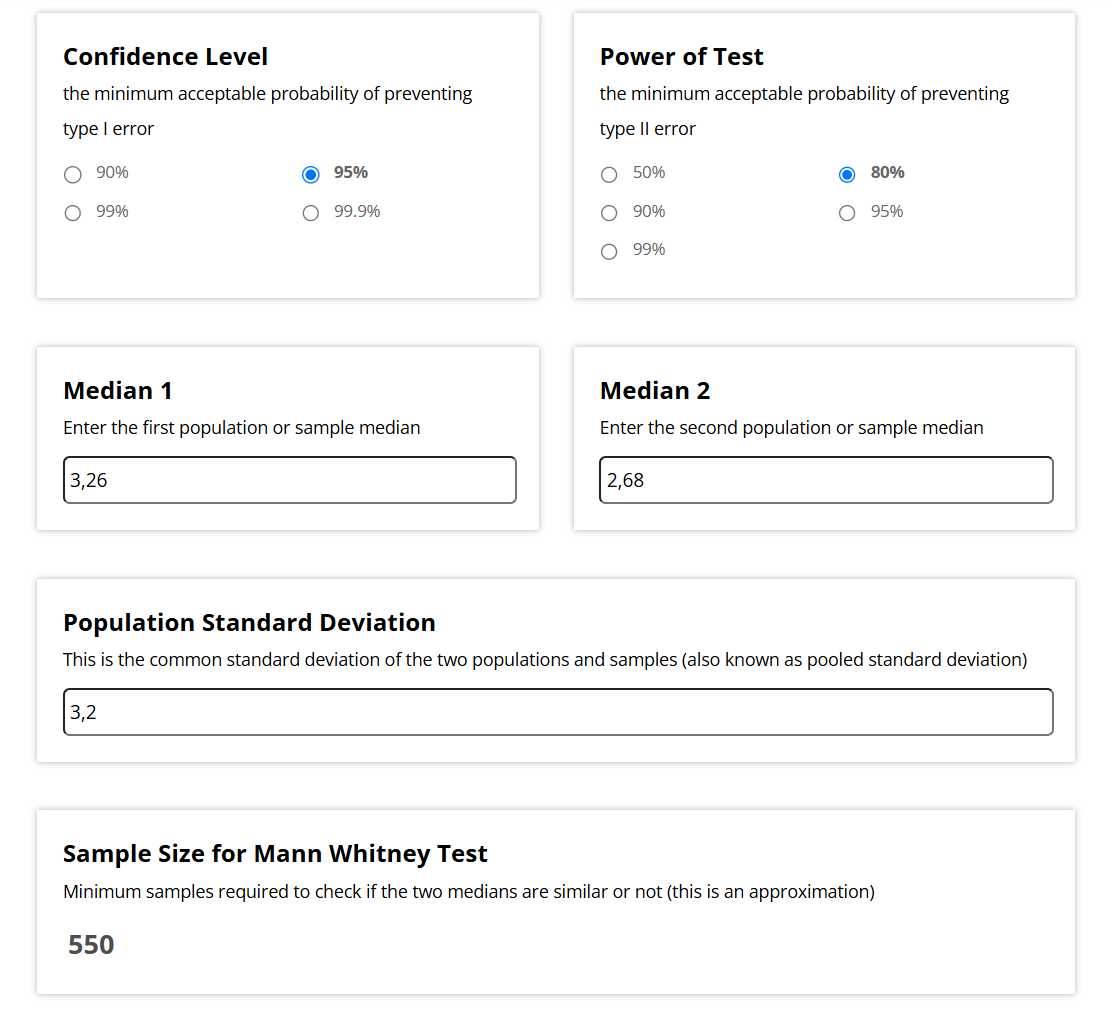

Получаем минимальный размер групп 550 пользователей. В нашем случае группы составляют 2.101 и 10.903 пользователя, что позволяет нам проводить тест.

Сформулируем гипотезы:

- $H_0$: cреднее количество заказов на одного пользователя мобильного устройства не выше* среднего количества заказов на одного пользователя стационарного устройства.
- $H_1$: среднее количество заказов на одного пользователя мобильного устройства выше по сравнению с пользователями стационарных устройств.

На самом деле, сразу можно предположить, что гипотеза $H_1$ в наших условиях подтверждена не будет, т.к. после исключения пользователей обоих типов устройств среднее число заказов на одного пользователя мобильного устройства оказалось ниже, чем на одного пользователя стационарного устройства:
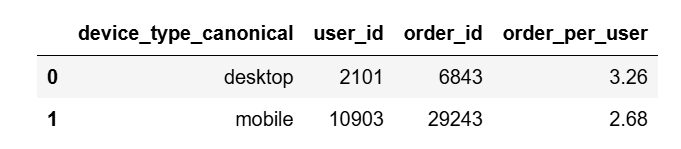

In [191]:
mobile = fn_filtered['order_id'].loc[fn_filtered['device_type_canonical'] == 'mobile']
desktop = fn_filtered['order_id'].loc[fn_filtered['device_type_canonical'] == 'desktop']

alpha = 0.05 

results = st.mannwhitneyu(
    mobile, 
    desktop,
    alternative='greater' # Альтернативная гипотеза, которую проверяем: mu1 > mu2
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 0.6909942219150887
Не получилось отвергнуть нулевую гипотезу.


Таким образом, мы не можем отвергнуть гипотезу $H_0$, т.е., вероятно, активность пользователей мобильных устройств (выраженная в среднем числе заказов на одного пользователя) не выше, чем активность пользователей стационарных устройств.

#### Среднее время между заказами

Сформируем таблицу на основе отфильтрованной по 95-му процентилю и без пользователей двух устройств.

In [192]:
fn_filt = pd.merge(fn_filtered, final_aut, on = 'user_id', how = 'left')

#display(fn_filt.info())

In [193]:
fn_filt_time = fn_filt[['user_id', 'device_type_canonical_x', 'order_id_y', 'days_since_prev']]
display(fn_filt_time.head())

,user_id,device_type_canonical_x,order_id_y,days_since_prev
0,0005ca5e93f2cf4,mobile,7292370,75.0
1,000898990054619,mobile,972400,83.0
2,000898990054619,mobile,2613713,19.0
3,000a55a418c128c,mobile,4657981,NaN
4,000a55a418c128c,mobile,4657952,16.0


In [194]:
fn_filt_time_gr = fn_filt_time.groupby(['user_id', 'device_type_canonical_x']).agg({'order_id_y':'count', 'days_since_prev':'mean'}).reset_index()

display(fn_filt_time_gr.head())
display(fn_filt_time_gr.info())
display(fn_filt_time_gr['days_since_prev'].describe())

,user_id,device_type_canonical_x,order_id_y,days_since_prev
0,0005ca5e93f2cf4,mobile,1,75.0
1,000898990054619,mobile,2,51.0
2,000a55a418c128c,mobile,2,16.0
3,001e7037d013f0f,mobile,2,43.5
4,00245c702bc343e,mobile,2,27.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13005 entries, 0 to 13004
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  13005 non-null  object 
 1   device_type_canonical_x  13005 non-null  object 
 2   order_id_y               13005 non-null  int64  
 3   days_since_prev          8391 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 406.5+ KB


None

count    8391.000000
mean       24.622225
std        30.719093
min         0.000000
25%         1.333333
50%        12.500000
75%        36.000000
max       148.000000
Name: days_since_prev, dtype: float64

Стандартное отклонение оказывается больше среднего арифметического, а среднее арифметическое - больше медианы, что свидетельствует о наличии выбросов. Однако в данном случае фильтровать их не стоит, поскольку они не представляют собой ошибочных или аномальных значений (максимальное значение - 148 дней, что вполне может соответствовать поведению клиентов билетных сервисов; скорее вопросы вызывает значение 0 дней между заказами).

Оценим количество выбросов.

In [195]:
boxplot10 = fn_filt_time_gr.loc[fn_filt_time_gr['device_type_canonical_x']=='mobile'].boxplot(column='days_since_prev',
                     vert=False,
                     color='black',
                     flierprops=dict(markerfacecolor='gold', markeredgecolor='grey', marker='o'),
                     medianprops=dict(color="red"),
                     figsize=(10, 4))
                            
boxplot10.set_title('Время между заказами (в днях) для мобильных устройств')
boxplot10.set_xlabel('Дни между заказами')
boxplot10.axes.get_yaxis().set_visible(False)

Оценим количество выбросов при 95-м процентиле данных.

In [196]:
np.nanpercentile(fn_filt_time_gr.loc[fn_filt_time_gr['device_type_canonical_x']=='mobile']['days_since_prev'], 95)

np.float64(94.0)

In [197]:
fn_filt_time_gr_95 = fn_filt_time_gr.loc[(fn_filt_time_gr['device_type_canonical_x'] == 'mobile') &
                                         (fn_filt_time_gr['days_since_prev'] <= np.nanpercentile(fn_filt_time_gr.loc[fn_filt_time_gr['device_type_canonical_x']=='mobile']['days_since_prev'], 95))]
display(fn_filt_time_gr_95.describe())

,order_id_y,days_since_prev
count,6673.00000,6673.000000
mean,4.04166,20.773215
std,6.73401,22.937709
min,1.00000,0.000000
25%,2.00000,2.142857
50%,3.00000,12.666667
75%,4.00000,31.666667
max,254.00000,94.000000


In [198]:
boxplot11 = fn_filt_time_gr_95.boxplot(column='days_since_prev',
                     vert=False,
                     color='black',
                     flierprops=dict(markerfacecolor='gold', markeredgecolor='grey', marker='o'),
                     medianprops=dict(color="red"),
                     figsize=(10, 4))
boxplot11.set_title('Время между заказами (в днях) для мобильных устройств, 95-й процентиль')
boxplot11.set_xlabel('Дни между заказами')
boxplot11.axes.get_yaxis().set_visible(False)

Всё равно наблюдаются выбросы. Брать 95-й процентиль не имеет смысла, тест нужно проводить на всех данных.

Поскольку в данных есть выбросы, опять же будем проводить тест Манна-Уитни.

Рассчитаем необходимый размер групп, для чего посчитаем средние значения промежутков между заказами для пользователей мобильных и стационарных устройств.

In [199]:
fn_filt_time_gr_total = fn_filt_time_gr.groupby('device_type_canonical_x').agg({'days_since_prev':'mean'}).reset_index()
fn_filt_time_gr_total['days_since_prev'] = round(fn_filt_time_gr_total['days_since_prev'], 2)
display(fn_filt_time_gr_total)

,device_type_canonical_x,days_since_prev
0,desktop,20.93
1,mobile,25.34


Воспользуемся калькулятором https://www.benchmarksixsigma.com/calculators/sample-size-calculator-for-mann-whitney-test/ для оценки необходимого размера групп.

Примем стандартные значения $\alpha=0.05$, доверительный интервал 0.95, $\beta=0.2$, мощность теста 0.8.

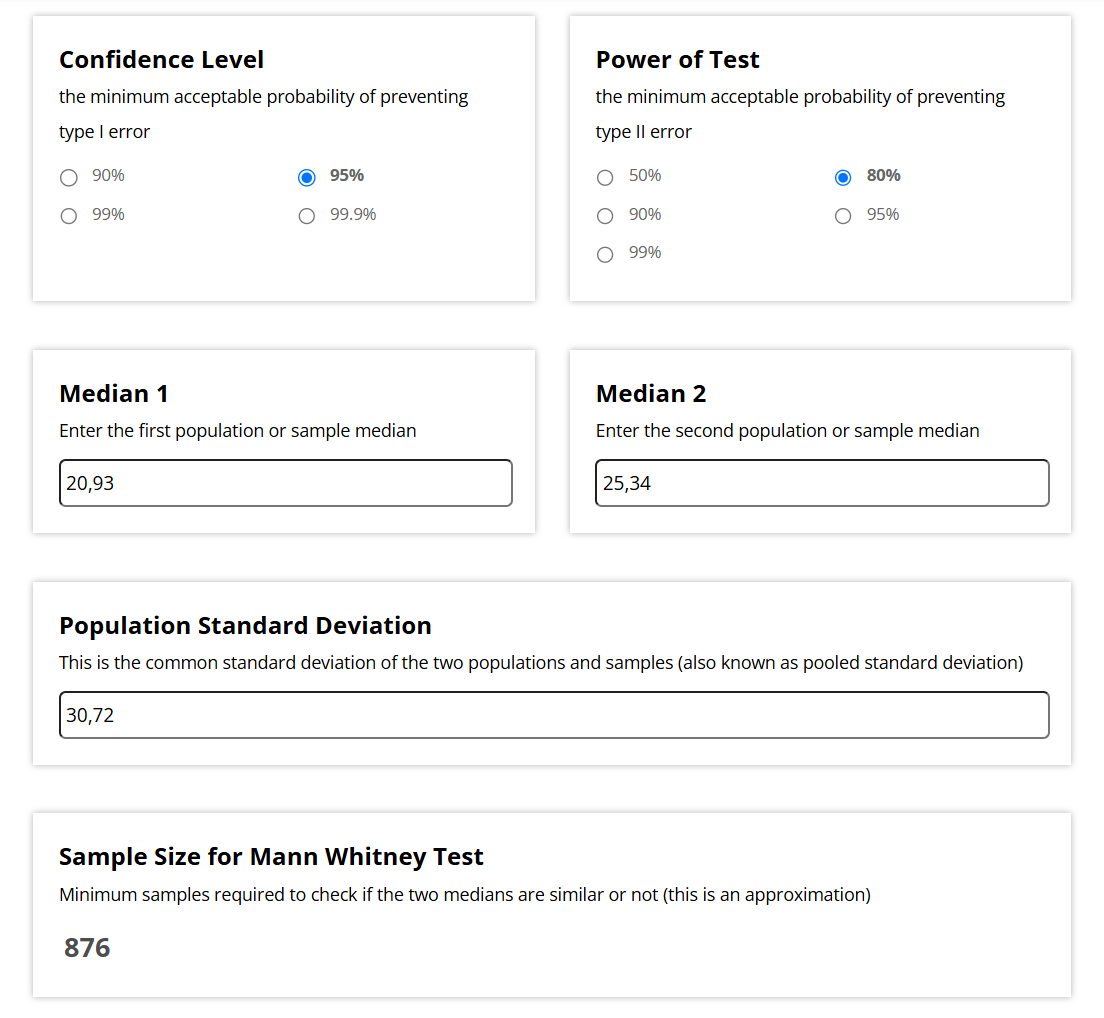

Получаем необходимый размер групп 876 пользователей, у нас, как мы выяснили ранее, размер групп - 2.101 и 10.903 пользователя, можем проводить тест.

Сформулируем гипотезы:
Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств

- $H_0$: cреднее время между заказами пользователей мобильных устройств не выше* среднего времени между заказами пользователей стационарных устройств.
- $H_1$: cреднее время между заказами пользователей мобильных устройств выше среднего времени между заказами пользователей стационарных устройств.

In [200]:
mobile_time = fn_filt_time_gr['days_since_prev'].loc[(fn_filt_time_gr['device_type_canonical_x'] == 'mobile')
                                                    & (~fn_filt_time_gr['days_since_prev'].isna())]
desktop_time = fn_filt_time_gr['days_since_prev'].loc[(fn_filt_time_gr['device_type_canonical_x'] == 'desktop')
                                                     & (~fn_filt_time_gr['days_since_prev'].isna())]

alpha = 0.05 

results = st.mannwhitneyu(
    mobile_time, 
    desktop_time,
    alternative='greater' # Альтернативная гипотеза, которую проверяем: mu1 > mu2
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

p-значение: 6.975448713258638e-28
Отвергаем нулевую гипотезу.


Получаем, что мы не можем отвергнуть гипотезу $H_1$, т.е., вероятно, cреднее время между заказами пользователей мобильных устройств действительно достоверно выше среднего времени между заказами пользователей стационарных устройств.

#### Промежуточный вывод

По итогам статистического анализа можно сделать следующие выводы:

- нельзя подтвердить гипотезу, что активность пользователей мобильных устройств (выраженная в среднем числе заказов на одного пользователя) выше, чем активность пользователей стационарных устройств;
- нельзя отвергнуть гипотезу, что cреднее время между заказами пользователей мобильных устройств выше среднего времени между заказами пользователей стационарных устройств.

### Общий вывод и рекомендации

#### Вывод

##### Анализ распределения заказов по сегментам и их сезонные изменения
1. Наблюдается увеличение количества заказов с июня по октябрь.
2. Распределение заказов, совершённых при помощи мобильных и стационарных устройств, не меняется в зависимости от сезона.
3. Осенью снижается спрос на мероприятия из категории "другое", но повышаются продажи билетов на спортивные мероприятия, театральные постановки и детские ёлки.
4. Осенью наблюдается увеличение спроса на мероприятия с возрастным ограничением 0+ и уменьшение спроса на мероприятия 18+. Распределение остальных мероприятий остаётся приблизительно таким же, как и летом.
5. Средняя выручка с билетов в театры, на ёлки и на концерты осенью снижается (на 17,81%, 15,16% и 10,92% соответственно), по остальным типам мероприятий она остаётся примерно такой же, как летом.
    
    
##### Анализ осенней активности пользователей
1. Динамика по дням в сентябре-октябре 2024 года:

    1. Наблюдается резкий рост числа заказов 1 октября, и в целом число заказов в день демонстрирует тенденцию к увеличению.
    2. Число уникальных активных пользователей (DAU) также растёт в течение двух месяцев.
    3. Есть тенденцию к незначительному увеличению среднего числа заказов на одного пользователя, кроме того, есть значительные пики по вторникам 03.09 и 01.10.
    4. Средняя выручка с одного билета не изменяется в течение сентября-октября, за исключением 03.09 и 01.10, когда она была низкой.
    
    
2. Динамика по дням недели в указанном периоде:

    1. Наибольшее среднее число заказов приходится на вторник. В среду, субботу, воскресенье и понедельник значения самые низкие.
    2. С понедельника по пятницу наблюдается рост DAU, в пятницу значение максимально, далее идёт снижение к воскресенью и понедельнику.
    3. Наибольшее среднее число заказов на одного пользователя наблюдается по вторникам.
    4. Наиболее низкая средняя выручка с одного билета также приходится на вторники.


##### Популярные события и партнёры
1. Лидерами по разнообразию и общему количеству проводимых мероприятий являются Каменевский район, Североярская и Широковская области.
2. В целом наиболее популярны концерты, мероприятия из категории "другое" и театральные постановки.
3. Абсолютными лидерами по совокупности параметров являются партнёры "Облачко", "Лови билет!" и "Билеты без проблем".
    
    
##### Статистический анализ данных за осенний период

Были выдвинуты две гипотезы относительно поведения пользователей в сентябре-октябре 2024 года:
1. Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
2. Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.


Итоги статистического анализа:
1. Среднее число заказов на одного пользователя мобильных устройств **не выше**, чем на одного пользователя стационарных устройств.
2. Среднее время между заказами пользователей мобильных устройств действительно **выше** среднего времени между заказами пользователей стационарных устройств.

#### Рекомендации

1. Дополнительно проверить, чем были вызваны резкие изменения в активности клиентов 3 сентября и 1 октября, поскольку данные за эти два дня существенно повлияли на недельную динамику показателей.
2. Стимулировать пользователей мобильных устройств совершать больше заказов и чаще, поскольку большинство заказов совершается именно этой категорией клиентов.
3. Стимулировать спрос на билеты в выходные.
4. Найти возможности увеличить спрос на билеты в летний период (скидки, акции, напоминания).